<a href="https://colab.research.google.com/github/SethJorissen/ANM_anomalies_project/blob/main/ANM_anomalies_project_phase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANM anomaly detection project - phase 2

Tsinghua 2023, produced by Aris Dressino and Seth Jorissen

## 1. initial set up

- fetch data for analysis
- import needed libraries

In [1]:
# fetch phase 1 and 2 data from github to colab working directory - run once
# consider using another method if working from local client
%%capture
#import shutil
#shutil.rmtree('/content/phase1')
!apt install subversion
!svn checkout https://github.com/SethJorissen/ANM_anomalies_project/trunk/phase1
!svn checkout https://github.com/SethJorissen/ANM_anomalies_project/trunk/phase2

In [2]:
# needed libraries
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
from tqdm import tqdm
from typing import Dict, List
from typing import List, Dict, Tuple, Set
import shutil

##2. Exploratory data analysis

- provide summary statistics and relevant analysis of the data
- plot relevant features of the dataset against timestamp



In [3]:
# import train set
# Set the path to the directory containing the CSV files
path = 'phase2/dataset/train/processed'

# Get a list of all CSV files in the directory
files = glob.glob(os.path.join(path, '*.csv'))

df_list = []
# Iterate over each file, read it into a DataFrame, and add a new column with the filename
for file in files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Add a new column with the filename without the extension
    filename = os.path.splitext(os.path.basename(file))[0]
    df['service'] = filename
    df_list.append(df)

# Concatenate all dataframes into a single dataframe
train = pd.concat(df_list, ignore_index=True)

train.head(5)

,timestamp,container_network_receive_packets_dropped.eth0,container_spec_cpu_shares,container_spec_memory_swap_limit_MB,container_fs_writes_MB./dev/vda,container_network_transmit_packets_dropped.eth0,container_network_receive_errors.eth0,container_fs_writes_merged./dev/vda1,container_threads_max,container_fs_write_seconds./dev/vda1,...,container_spec_cpu_period,container_memory_swap,container_threads,container_network_transmit_errors.eth0,container_spec_memory_limit_MB,container_fs_reads_merged./dev/vda1,container_network_transmit_MB.eth0,container_cpu_system_seconds,container_cpu_load_average_10s,service
0,1647619260,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,25.0,0.0,256.0,0.0,0.441070,0.005,0.0,shippingservice-0
1,1647619320,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,25.0,0.0,256.0,0.0,0.455602,0.005,0.0,shippingservice-0
2,1647619380,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,25.0,0.0,256.0,0.0,0.546195,0.000,0.0,shippingservice-0
3,1647619440,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,25.0,0.0,256.0,0.0,0.352804,0.010,0.0,shippingservice-0
4,1647619500,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,25.0,0.0,256.0,0.0,0.446267,0.000,0.0,shippingservice-0


In [4]:
# describe numerical metrics of train dataset
train.describe()

,timestamp,container_network_receive_packets_dropped.eth0,container_spec_cpu_shares,container_spec_memory_swap_limit_MB,container_fs_writes_MB./dev/vda,container_network_transmit_packets_dropped.eth0,container_network_receive_errors.eth0,container_fs_writes_merged./dev/vda1,container_threads_max,container_fs_write_seconds./dev/vda1,...,container_cpu_cfs_periods,container_spec_cpu_period,container_memory_swap,container_threads,container_network_transmit_errors.eth0,container_spec_memory_limit_MB,container_fs_reads_merged./dev/vda1,container_network_transmit_MB.eth0,container_cpu_system_seconds,container_cpu_load_average_10s
count,6.043800e+04,60438.0,57560.000000,57560.000000,57560.0,60438.0,60438.0,57560.0,57560.0,57560.0,...,57560.000000,57560.0,57560.0,57560.000000,60438.0,57560.000000,57560.0,60438.000000,57560.000000,57560.0
mean,1.647662e+09,0.0,206.700000,368.125000,0.0,0.0,0.0,0.0,0.0,0.0,...,113.878423,100000.0,0.0,25.588870,0.0,368.125000,0.0,1.341939,0.060221,0.0
std,2.492441e+04,0.0,95.695972,280.152678,0.0,0.0,0.0,0.0,0.0,0.0,...,97.499338,0.0,0.0,4.989798,0.0,280.152678,0.0,1.425130,0.100049,0.0
min,1.647619e+09,0.0,102.000000,128.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,100000.0,0.0,15.000000,0.0,128.000000,0.0,0.049372,0.000000,0.0
25%,1.647641e+09,0.0,102.000000,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,25.000000,100000.0,0.0,21.000000,0.0,224.000000,0.0,0.381905,0.010000,0.0
50%,1.647662e+09,0.0,204.000000,256.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,98.000000,100000.0,0.0,27.000000,0.0,256.000000,0.0,0.939109,0.025000,0.0
75%,1.647684e+09,0.0,204.000000,465.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,174.000000,100000.0,0.0,29.000000,0.0,465.500000,0.0,1.738056,0.055000,0.0
max,1.647706e+09,0.0,409.000000,1025.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,506.000000,100000.0,0.0,41.000000,0.0,1025.000000,0.0,8.847941,0.670000,0.0


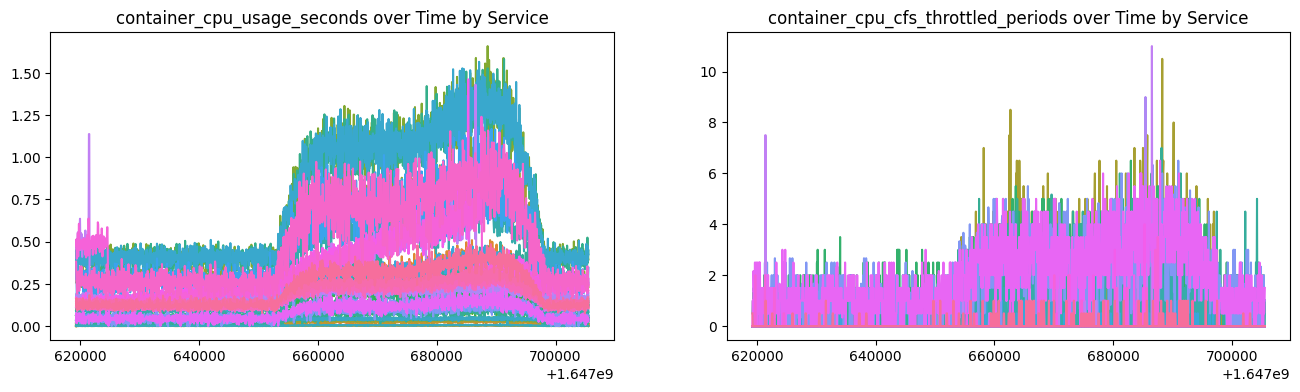

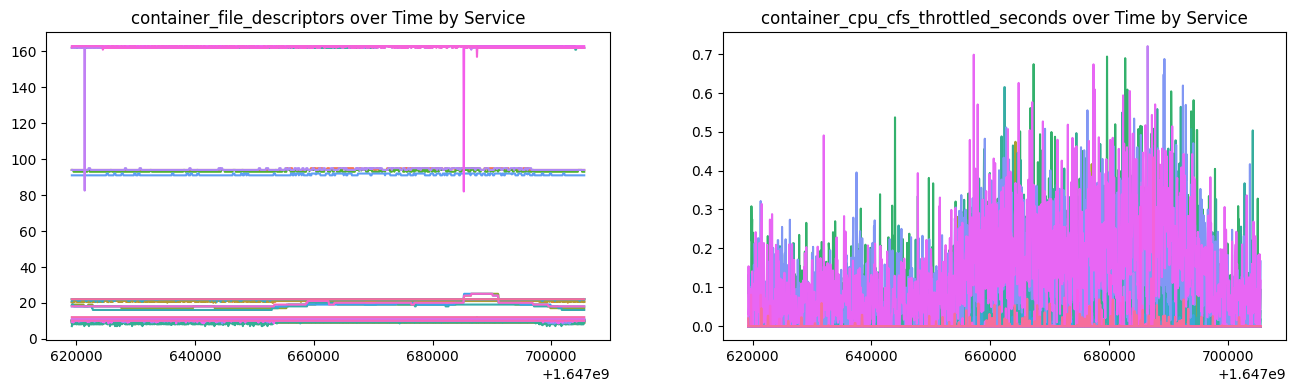

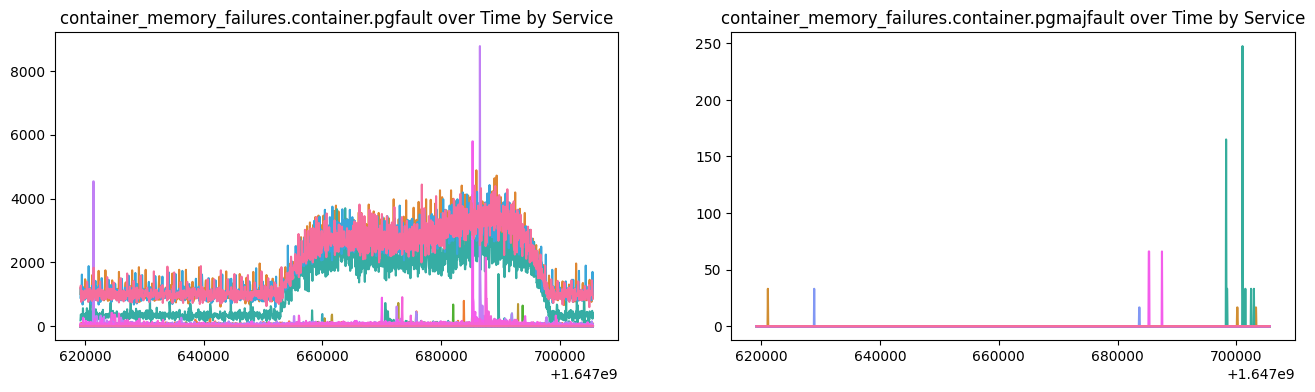

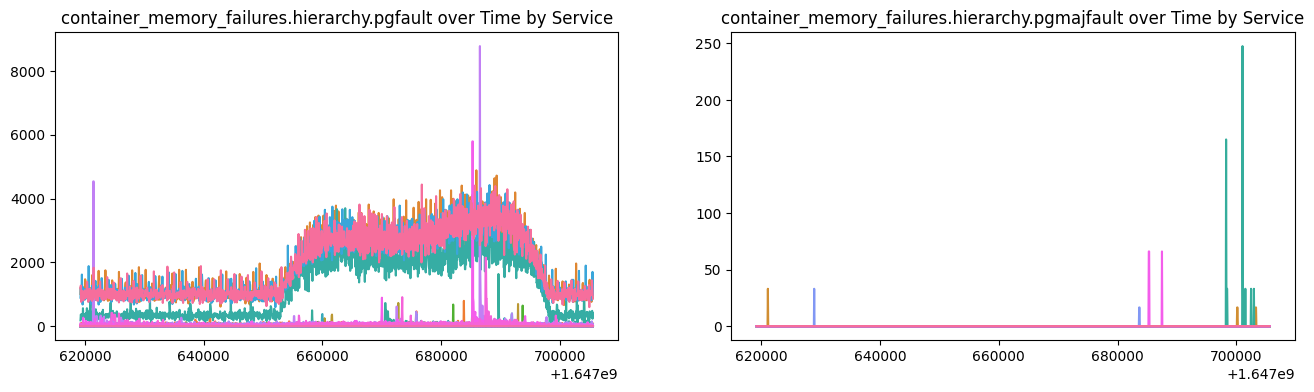

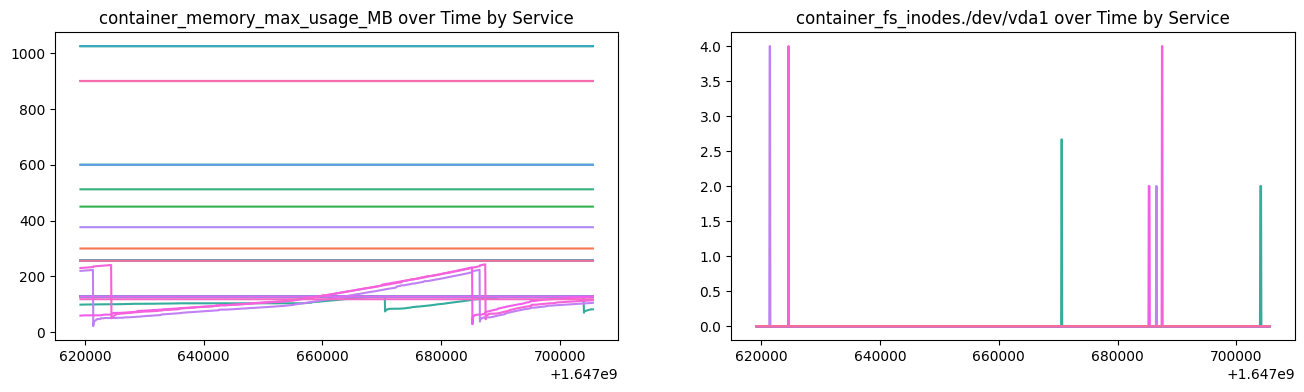

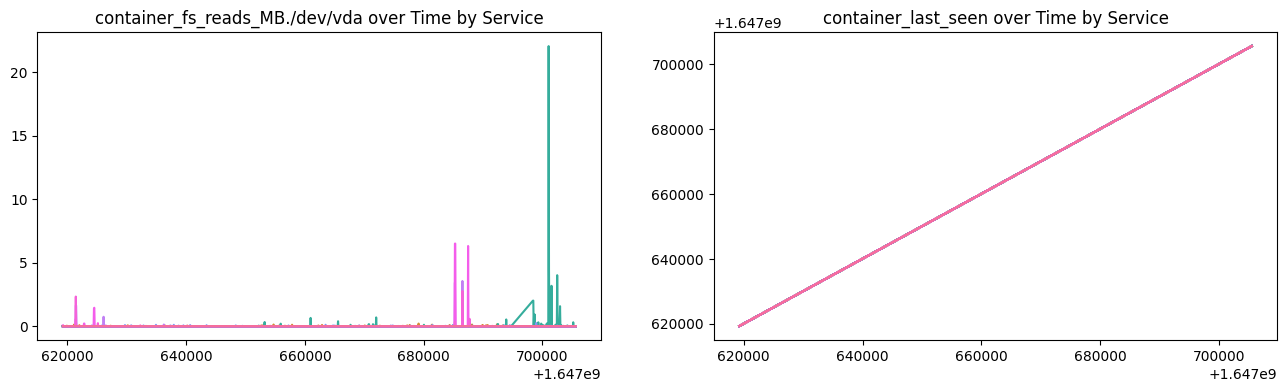

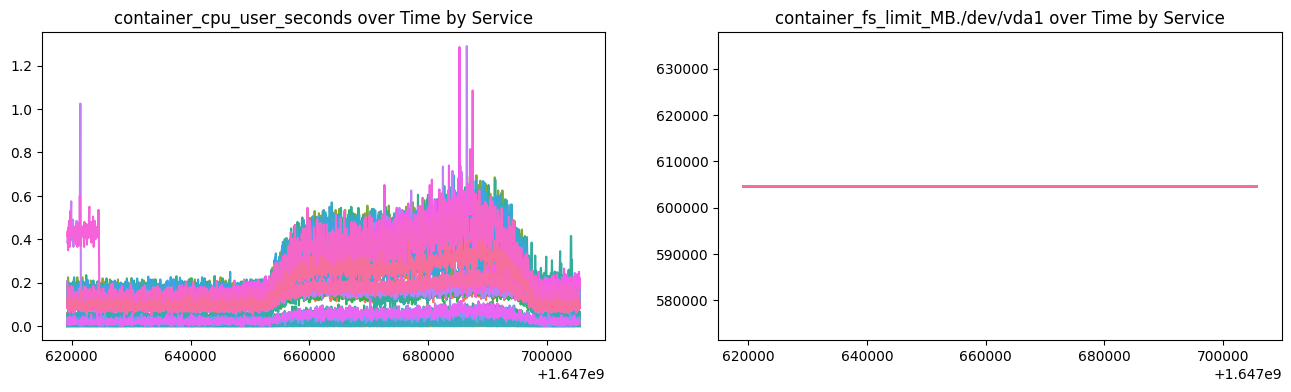

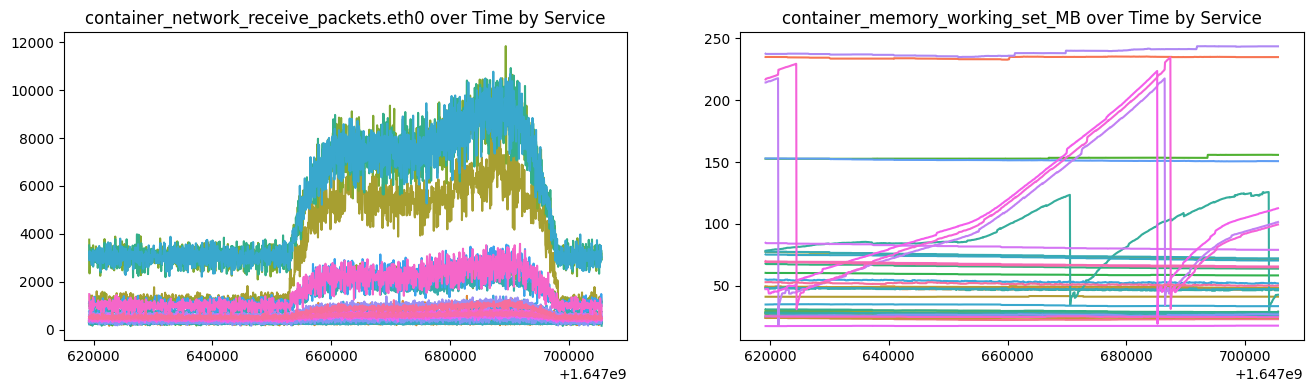

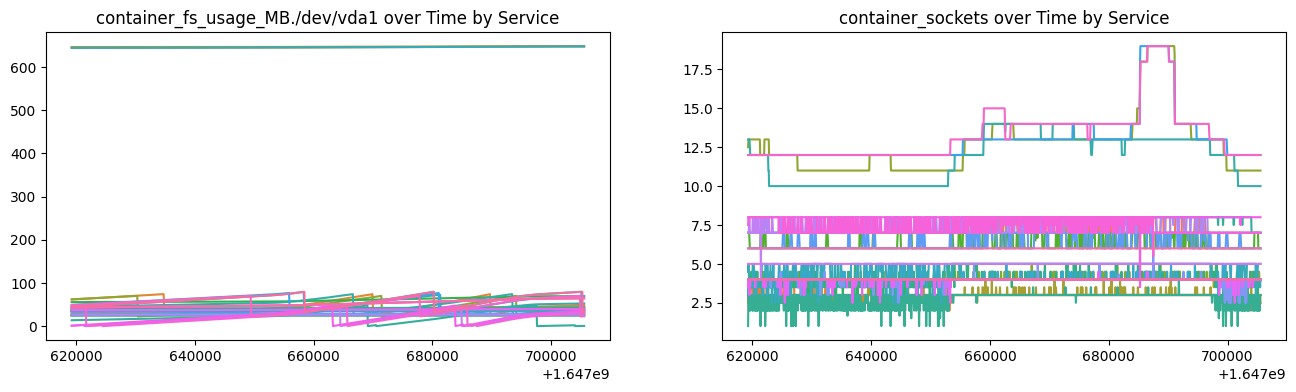

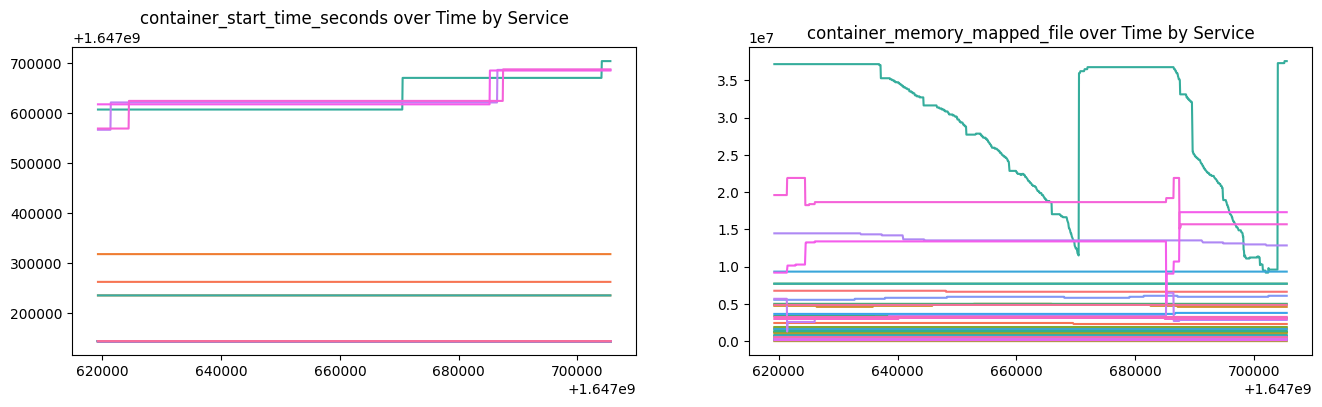

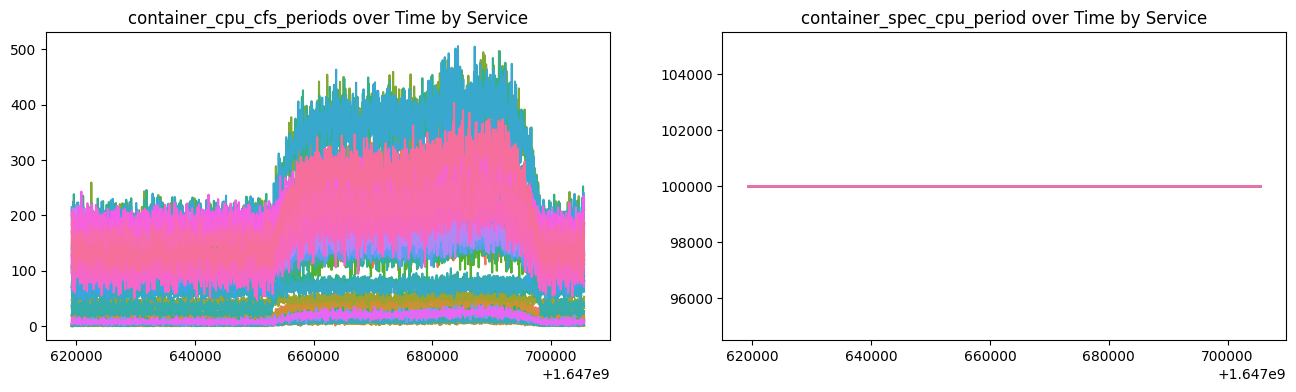

In [5]:
# Loop over all columns in the DataFrame except "timestamp" and "service"
cols = train.columns.drop(["timestamp", "service"])
for i in range(0, len(cols), 2):
    col1 = cols[i]
    col2 = cols[i+1] if i+1 < len(cols) else None

    # Check if all values in the column are 0 or the same value
    if (len(train[col1].unique()) == 1 or train[col1].sum() == 0) or (not col2 or (len(train[col2].unique()) == 1 or train[col2].sum() == 0)):
        continue

    # Check if the values are equal when grouped by service for both columns
    if col2:
        grouped1 = train.groupby('service')[col1].nunique()
        grouped2 = train.groupby('service')[col2].nunique()
        if len(grouped1.unique()) == 1 or len(grouped2.unique()) == 1:
            continue
        
    # Create a new row of subplots with 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    # Create the first plot in the left column
    sns.lineplot(x="timestamp", y=col1, hue="service", data=train, ax=axs[0])
    axs[0].set_title(f"{col1} over Time by Service")

    # Remove the legend from the first plot
    axs[0].get_legend().remove()

    # Create the second plot in the right column if there is a second column
    if col2:
        sns.lineplot(x="timestamp", y=col2, hue="service", data=train, ax=axs[1])
        axs[1].set_title(f"{col2} over Time by Service")

        # Remove the legend from the second plot
        axs[1].get_legend().remove()

    # Remove axis labels from all subplots
    for ax in axs:
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Set the height of all subplots to the same value
    fig.subplots_adjust(hspace=0.4)

    # Add a border to the row of subplots
    for ax in axs:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

    # Show the row of subplots
    plt.show()



##3. Anomaly Localization

This model first creates an anomaly detection model for all microservices using a LSTM AE. This model will return a series of anomaly scores over time and a boolean which indicates whether the threshold was breached.

Then a root cause analasis starts. The edges and nodes of the topology graph will be given weights. The nodes of this graph will be ranked by PageRank.

###3.1 Data management

This class will prepare the data in the test/train folders. Given a folder it will load all csv files and and put them in a dictionary with their name as key. It gets rid of NaN values and removes irrelavent columns.

In [3]:
class DataManager:
    def __init__(self, 
                 data_path: str,
                 train: bool = False,
                 ignore_columns=None):
        if ignore_columns is None:
            ignore_columns = [
                'timestamp',
                'container_start_time_seconds',
                'container_last_seen']
        self.data_path = data_path
        self.ignore_columns = ignore_columns
        self.train = train

        # Load from file
        self.data: Dict[str, np.ndarray] = {}
        self.columns: List[str] = []
        self.__load()

    def __fill_na(self, df: pd.DataFrame):
        if self.train:
            df.interpolate(method='linear', inplace=True)
        df.fillna(0.0, inplace=True)

    def __load(self):
        for file in os.listdir(self.data_path):
            if not file.endswith('.csv'):
                continue

            cur_df = pd.read_csv(os.path.join(self.data_path, file), engine='c')
            self.__fill_na(cur_df)
            self.columns = sorted([i for i in cur_df.columns.values if i not in self.ignore_columns])
            self.data[file[:-4]] = cur_df[self.columns].values

    def get(self, s: str) -> np.ndarray:
        return self.data[s]

###3.2 Anomaly detection

The anomaly detection model uses two classes:
- $LSTMAEDetector$ holds a LSTM AE to detect anomolies in a microservice. Before fitting the model, it first prepares the input data by scaling and creating sequences. Then it defines the model and fits it on the data. Finally the loss is scaled so all microservices can use the same threshold. To make a prediction, the data is prepared the same way and the scaled reconstruction loss of the model is calculated. This will be the anomaly score. All the anomaly scores will be returned and it will also check whether the threshold was breached at any point.

- The anomaly detector class will create and fit the LSTM AE Detectors of all microservices. When detecting an anomoly, it will call the detector of all microservices and return whether they encountered an anomaly and their anomaly scores.





In [24]:
# DBSCAN

from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances

class GraphBasedDetector:
    def __init__(self):
        self.detector = None

    def fit(self, data: np.ndarray):
        # Compute pairwise distances between data points
        distances = pairwise_distances(data)

        # Use DBSCAN for clustering
        self.detector = DBSCAN(eps=0.5, min_samples=5)
        self.detector.fit(distances)

    def decision_function(self, data: np.ndarray):
        # Data: [timesteps x features]
        distances = pairwise_distances(data)
        labels = self.detector.labels_

        # Calculate anomaly scores based on cluster membership
        anomaly_scores = np.zeros_like(labels, dtype=float)
        unique_labels = np.unique(labels)

        for label in unique_labels:
            if label == -1:  # Outliers
                anomaly_scores[labels == label] = 1.0
            else:
                cluster_indices = np.where(labels == label)[0]
                cluster_distances = distances[cluster_indices][:, cluster_indices]
                min_distances = np.min(cluster_distances, axis=1)
                max_distance = np.max(min_distances)
                anomaly_scores[labels == label] = 1.0 - min_distances / max_distance

        return anomaly_scores

class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, Any] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = GraphBasedDetector()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def decision_function(self, data: np.ndarray):
        anomalies: Dict[str, bool] = {}
        anomaly_scores: Dict[str, np.ndarray] = {}

        for k, v in data.data.items():
            detector = self.detector_dict[k]
            scores = detector.decision_function(v)
            anomaly_scores[k] = scores
            anomalies[k] = scores > self.hyper_params['anomaly_threshold']

        return anomalies, anomaly_scores

    def detect(self, data: DataManager):
        # Simply return the max anomaly degree of all metrics
        result: Dict[str, float] = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)

            assert type(detect_result) == np.ndarray
            result[k] = np.mean(detect_result)

        return result


In [28]:
# GRAPH BASED DETECTOR

from sklearn.neighbors import LocalOutlierFactor

class GraphBasedDetector:
    def __init__(self):
        self.detector = None

    def fit(self, data: np.ndarray):
        self.detector = LocalOutlierFactor(contamination='auto')
        self.detector.fit(data)

    def decision_function(self, data: np.ndarray):
        # Data: [timesteps x features]
        scores = self.detector.negative_outlier_factor_
        anomaly_scores = np.ones_like(scores) - (1 + scores) / 2
        return anomaly_scores

class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, Any] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = GraphBasedDetector()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def decision_function(self, data: np.ndarray):
        anomalies: Dict[str, bool] = {}
        anomaly_scores: Dict[str, np.ndarray] = {}

        for k, v in data.data.items():
            detector = self.detector_dict[k]
            scores = detector.decision_function(v)
            anomaly_scores[k] = scores
            anomalies[k] = scores > self.hyper_params['anomaly_threshold']

        return anomalies, anomaly_scores

    def detect(self, data: DataManager):
        # Simply return the max anomaly degree of all metrics
        result: Dict[str, float] = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)

            assert type(detect_result) == np.ndarray
            result[k] = np.mean(detect_result)

        return result


In [10]:
# SVM BASED DETECTOR

from sklearn.svm import OneClassSVM

class SVMBasedDetector:
    def __init__(self):
        self.detector = None

    def fit(self, data: np.ndarray):
        self.detector = OneClassSVM(nu=0.1)
        self.detector.fit(data)

    def decision_function(self, data: np.ndarray):
        # Data: [timesteps x features]
        scores = self.detector.decision_function(data)
        anomaly_scores = np.ones_like(scores) - (1 + scores) / 2
        return anomaly_scores

class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, Any] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = SVMBasedDetector()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def decision_function(self, data: np.ndarray):
        anomalies: Dict[str, bool] = {}
        anomaly_scores: Dict[str, np.ndarray] = {}

        for k, v in data.data.items():
            detector = self.detector_dict[k]
            scores = detector.decision_function(v)
            anomaly_scores[k] = scores
            anomalies[k] = scores > self.hyper_params['anomaly_threshold']

        return anomalies, anomaly_scores

    def detect(self, data: DataManager):
        # Simply return the max anomaly degree of all metrics
        result: Dict[str, float] = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)

            assert type(detect_result) == np.ndarray
            result[k] = np.mean(detect_result)

        return result

In [4]:
# ISOLATION FOREST

from sklearn.ensemble import IsolationForest

class IsolationForestDetector:
    def __init__(self):
        self.detector = None

    def fit(self, data: np.ndarray):
        self.detector = IsolationForest()
        self.detector.fit(data)

    def decision_function(self, data: np.ndarray):
        scores = self.detector.decision_function(data)
        anomaly_scores = np.ones_like(scores) - (1 + scores) / 2
        return anomaly_scores

class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = IsolationForestDetector()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def decision_function(self, data: np.ndarray):
        anomalies = {}
        anomaly_scores = {}

        for k, v in data.data.items():
            detector = self.detector_dict[k]
            scores = detector.decision_function(v)
            anomaly_scores[k] = scores
            anomalies[k] = scores > self.hyper_params['anomaly_threshold']

        return anomalies, anomaly_scores

    def detect(self, data: DataManager):
        result = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)
            assert isinstance(detect_result, np.ndarray)
            result[k] = np.mean(detect_result)

        return result


In [15]:
# K SIGMA DETECTOR

class KSigmaDetecor:
    def __init__(self):
        pass

    def fit(self, data: np.ndarray):
        self.lam = np.mean(data, axis=0, keepdims=True)

    def decision_function(self, data: np.ndarray):
        # Data: [timesteps x features]

        data_lam = np.mean(data, axis=0, keepdims=True)

        return np.ones_like(data_lam) - np.exp(-1*np.square(np.sqrt(self.lam) - np.sqrt(data_lam)))


class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, KSigmaDetecor] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = KSigmaDetecor()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def detect(self, data: DataManager):
        # Simply return the max anomaly degree of all metrics
        result: Dict[str, float] = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)

            assert type(detect_result) == np.ndarray
            result[k] = np.mean(detect_result)

        return result

###3.3 Root cause localization
The root cause localization will rank all microservices based on the probability that they are the root cause of the anomaly. The ranker has to be initialized with an anomalydetector. To start ranking the microservices their anomaly scores are calculated. Afterwards, the algorithm will use following scoring formula to perform a simplified version of pagerank:

$$v_{t+1} = (1 - c)Pv_t + cu$$

where $v$ holds the score of all nodes, $P$ is a matrix holding the weights of all edges and $u$ is a vector with for each microservice, the max anomaly score. For all edges in the topology, $P$ is equal to the pearson correlation of the nodes it connects and 0 for all other edges. This means that the score for the nodes $v$ is parially defined by the anomaly score of the microservice and partially by the score of their parent nodes. However, that depends on the corralation between their anomaly scores.

This algrorithm is based on the MicroRCA algorithm, but we do not have all the data they had.

Li Wu, Johan Tordsson, Erik Elmroth, Odej Kao. MicroRCA: Root Cause Localization of Performance
Issues in Microservices. IEEE/IFIP Network Operations and Management Symposium (NOMS), Apr
2020, Budapest, Hungary. ffhal-02441640f

https://inria.hal.science/hal-02441640

In [16]:
class Ranker:
    """
        This is a naive ranking algorithm, which simply rank according to the anomaly scores.
    """
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params

        self.train_data = DataManager(hyper_params['train_dir'])
        self.anomaly_detector = AnomalyDetector(hyper_params)
        self._init_ranker()
    
    def _init_ranker(self):
        self.anomaly_detector.fit(self.train_data)

    def rank(self, case_dir: str):     
        # Load test data
        test_data = DataManager(case_dir)

        # Detect anomaly
        anomaly_score = self.anomaly_detector.detect(test_data)
        print(anomaly_score)

        # TODO: You need to modify the ranking algorithm to achieve better results!   
        # This is a naive ranking algorithm, which simply rank according to the anomaly scores.
        rank_result = sorted(list(anomaly_score.keys()), key=lambda x: anomaly_score[x], reverse=True)

        return rank_result


###3.4 Training

In [17]:
"""
hyper_params = {
    'train_dir': 'phase2/dataset/train/processed',
    'test_dir': 'phase2/dataset/test/processed',
    'label_path': 'phase2/dataset/test/label.json',
    'topology': 'phase1/dataset/topology/service_topology.json'
}
"""

hyper_params = {
    'train_dir': 'phase1/dataset/train/processed',
    'test_dir': 'phase1/dataset/test/processed',
    'label_path': 'phase1/dataset/test/label.json',
    'topology': 'phase1/dataset/topology/service_topology.json'
}



ranker = Ranker(hyper_params)

Fitting detector(s): 100%|██████████| 42/42 [00:00<00:00, 5936.34it/s]


##4. evaluation, prediction and metrics

- evaluate test set anomalies and rank them
- compare labels with predicted ranking
- information regarding indexing are provided

In [18]:
class Evaluator:
    """
        Evaluate the localization algorithm with the give label.
    """
    def __init__(self, label_path: str):
        self.label_path = label_path

        with open(self.label_path, 'rt') as f:
            self.label = json.load(f)

    def evaluate(self, detect_results: List[List[str]], topk: List[int] = [1, 10, 20], write_report: bool=False):
        """
            Input: List of cases. Each case is a ranked list of root causes from the most likely ones to the least likely ones.
            Print the evaluation result.
        """
        all_ranks: List[int] = []
        topk_hit: List[List[int]] = []

        for i, case in enumerate(detect_results):
            cur_label = self.label['cmdb_id'][i]

            # Cur_rank is the rank of current case. Default is length of the list + 1.
            cur_rank = len(case) + 1
            for rank, root_cause in enumerate(case):
                if cur_label in root_cause:
                    cur_rank = rank + 1
                    break
            
            all_ranks.append(cur_rank)
            
            # Calculate the topk hit for current case.
            cur_topk_hit = []
            for k in topk:
                if cur_rank <= k:
                    cur_topk_hit.append(1)
                else:
                    cur_topk_hit.append(0)
            topk_hit.append(cur_topk_hit)

            # Write report if true
            if write_report:
                os.makedirs("report", exist_ok=True)
                report_content = f"Label: {cur_label}\n========List=======\n"
                for rank, root_cause in enumerate(case):
                    report_content += f"{rank}: {root_cause}\n"
                    if cur_label in root_cause:
                        report_content += "^ ROOT CAUSE\n"
                with open(os.path.join("report", f"{i}.txt"), "wt") as f:
                    f.write(report_content)

        # Calculate the average results
        mrr = np.mean(1 / np.array(all_ranks))
        avg_topk_hit = np.mean(topk_hit, axis=0)

        # Report the result
        report: str = "--------------Report-------------\n"
        for i in range(len(all_ranks)):
            report += f"Case {i}: "
            for j, k in enumerate(topk):
                report += f"Top {k}: {topk_hit[i][j]}\t"
            report += f"Rank: {all_ranks[i]}\n"

        report += "============AVG=============="
        for j, k in enumerate(topk):
            report += f"Top {k}: {avg_topk_hit[j]:.4f}, "
        report += f"MRR: {mrr:.4f}"
        print(report)

In [8]:
# Generate a list of lists containing the labels for the test set of phase 1 only
# Load the JSON file
with open('phase1/dataset/test/label.json', 'r') as json_file:
    data = json.load(json_file)

df_labels = pd.DataFrame(data)
labels = df_labels.values.tolist()

print(labels)

[[1648486942, 'emailservice-0'], [1648491433, 'recommendationservice2-0'], [1648492533, 'currencyservice-1'], [1648507813, 'paymentservice-1'], [1648512399, 'productcatalogservice-0'], [1648518075, 'shippingservice2-0'], [1648520175, 'productcatalogservice-0'], [1648522456, 'paymentservice-0'], [1648525065, 'frontend2-0'], [1648540678, 'shippingservice-2'], [1648541744, 'frontend2-0'], [1648552790, 'adservice2-0'], [1648558337, 'recommendationservice-2'], [1648560649, 'cartservice-2'], [1648561519, 'emailservice-2'], [1648565706, 'frontend2-0'], [1648550137, 'cartservice-1'], [1648525567, 'cartservice-1'], [1648491097, 'paymentservice-2'], [1648494319, 'adservice-2'], [1648506344, 'productcatalogservice-1'], [1648516367, 'productcatalogservice-0'], [1648528148, 'recommendationservice-1'], [1648528984, 'shippingservice-2'], [1648531433, 'cartservice-2'], [1648540897, 'shippingservice-2'], [1648549152, 'emailservice-2'], [1648551076, 'shippingservice-2'], [1648552118, 'recommendationserv

In [19]:
result_list = []
case_idx: int = 0
with tqdm(total=len(os.listdir(hyper_params['test_dir']))) as t:
    while True:
        case_dir = os.path.join(hyper_params['test_dir'], str(case_idx))
        if not os.path.exists(case_dir):
            break
        t.set_description(f"Ranking {case_dir}")

        cur_rank = ranker.rank(case_dir)
        print("")
        print("the anomaly label is: ", labels[case_idx])
        print(cur_rank)
        for l in cur_rank:
          if l == labels[case_idx][1]:
            print("in the current rank, the original amonaly is in position ", cur_rank.index(l))
            break
        print("\n")
        result_list.append(cur_rank)

        # Update tqdm
        t.update()
        case_idx += 1

evaluator = Evaluator(hyper_params['label_path'])

evaluator.evaluate(result_list)

Ranking phase1/dataset/test/processed/1:   1%|          | 1/92 [00:00<00:32,  2.77it/s]

{'shippingservice-0': 0.1691155380103652, 'shippingservice-1': 0.14600435329381606, 'adservice2-0': 0.1560761312430127, 'paymentservice-2': 0.11521699005743272, 'currencyservice-2': 0.2014002928074762, 'shippingservice-2': 0.16934145857333444, 'shippingservice2-0': 0.1523638740683244, 'paymentservice-0': 0.12954327842815402, 'paymentservice2-0': 0.1798193381290107, 'productcatalogservice2-0': 0.19985504678847835, 'emailservice-0': 0.21823001541019751, 'frontend-0': 0.17500395317234332, 'productcatalogservice-1': 0.14087371547891625, 'redis-cart2-0': 0.030965452941356403, 'adservice-2': 0.14022580899919884, 'recommendationservice2-0': 0.18659176891152335, 'checkoutservice-0': 0.2358733984448823, 'emailservice2-0': 0.12449742013648984, 'productcatalogservice-0': 0.14631132618618745, 'checkoutservice2-0': 0.20129009710027082, 'cartservice2-0': 0.2948667324188518, 'currencyservice2-0': 0.21329605832909657, 'frontend2-0': 0.19765691681562605, 'emailservice-2': 0.09196537536448143, 'payments

Ranking phase1/dataset/test/processed/2:   2%|▏         | 2/92 [00:00<00:28,  3.17it/s]

{'shippingservice-0': 0.16374604404359627, 'shippingservice-1': 0.14150933985161923, 'adservice2-0': 0.13703400731593166, 'paymentservice-2': 0.10717968474511977, 'currencyservice-2': 0.19599479274816048, 'shippingservice-2': 0.14409723502669997, 'shippingservice2-0': 0.15904134782556326, 'paymentservice-0': 0.13112504379579765, 'paymentservice2-0': 0.17935561162117508, 'productcatalogservice2-0': 0.20050773462134372, 'emailservice-0': 0.09652966431316883, 'frontend-0': 0.17632719290603005, 'productcatalogservice-1': 0.13352612798665972, 'redis-cart2-0': 0.030892926863517262, 'adservice-2': 0.13690971936353655, 'recommendationservice2-0': 0.2673015770134693, 'checkoutservice-0': 0.28317281143934137, 'emailservice2-0': 0.12282332640570497, 'productcatalogservice-0': 0.15317664207215373, 'checkoutservice2-0': 0.21379930990292387, 'cartservice2-0': 0.2903868003213315, 'currencyservice2-0': 0.2129478536793408, 'frontend2-0': 0.19639226320332434, 'emailservice-2': 0.08898353478891466, 'paym

Ranking phase1/dataset/test/processed/3:   3%|▎         | 3/92 [00:00<00:24,  3.68it/s]

{'shippingservice-0': 0.16420143569233364, 'shippingservice-1': 0.14421078460901196, 'adservice2-0': 0.13736935471193357, 'paymentservice-2': 0.10918972302827289, 'currencyservice-2': 0.19795543393690473, 'shippingservice-2': 0.1419895283155819, 'shippingservice2-0': 0.15324092682150445, 'paymentservice-0': 0.12625659467230632, 'paymentservice2-0': 0.17817756471149282, 'productcatalogservice2-0': 0.20017285792218634, 'emailservice-0': 0.09587104387510473, 'frontend-0': 0.1765657173304327, 'productcatalogservice-1': 0.14083730314243442, 'redis-cart2-0': 0.030861805744142427, 'adservice-2': 0.14644368050976272, 'recommendationservice2-0': 0.25705742322376757, 'checkoutservice-0': 0.2818698100360908, 'emailservice2-0': 0.12232501690385404, 'productcatalogservice-0': 0.14624065373347744, 'checkoutservice2-0': 0.21398112242986703, 'cartservice2-0': 0.28521690953441237, 'currencyservice2-0': 0.21297654929320803, 'frontend2-0': 0.19643808278325373, 'emailservice-2': 0.08884527750498289, 'paym

Ranking phase1/dataset/test/processed/4:   4%|▍         | 4/92 [00:01<00:22,  3.89it/s]

{'shippingservice-0': 0.16298488715613363, 'shippingservice-1': 0.1432037562371041, 'adservice2-0': 0.16925265355983468, 'paymentservice-2': 0.11832962052650371, 'currencyservice-2': 0.19614581140627674, 'shippingservice-2': 0.14706614029829884, 'shippingservice2-0': 0.15485646529007904, 'paymentservice-0': 0.1316471131300288, 'paymentservice2-0': 0.17936956818241573, 'productcatalogservice2-0': 0.20092265889200334, 'emailservice-0': 0.09420003869155587, 'frontend-0': 0.2107168705813033, 'productcatalogservice-1': 0.1410403181215513, 'redis-cart2-0': 0.030613952104580285, 'adservice-2': 0.22476913290161413, 'recommendationservice2-0': 0.1884048903819557, 'checkoutservice-0': 0.3276297094631295, 'emailservice2-0': 0.11662598762619694, 'productcatalogservice-0': 0.14168099858064712, 'checkoutservice2-0': 0.21349920754432739, 'cartservice2-0': 0.1940002233181749, 'currencyservice2-0': 0.21100100859947124, 'frontend2-0': 0.16005749813901396, 'emailservice-2': 0.08595268292263444, 'payments

Ranking phase1/dataset/test/processed/5:   5%|▌         | 5/92 [00:01<00:21,  4.12it/s]

{'shippingservice-0': 0.1779311929284347, 'shippingservice-1': 0.13438463931848166, 'adservice2-0': 0.14154836148727795, 'paymentservice-2': 0.11418400467364027, 'currencyservice-2': 0.19949218750215902, 'shippingservice-2': 0.17933659330789228, 'shippingservice2-0': 0.1540094752853922, 'paymentservice-0': 0.11694266524397252, 'paymentservice2-0': 0.1799849373867441, 'productcatalogservice2-0': 0.18676286955243895, 'emailservice-0': 0.09449584804936169, 'frontend-0': 0.20448965153770016, 'productcatalogservice-1': 0.14255022356493374, 'redis-cart2-0': 0.0307179280621801, 'adservice-2': 0.1759467509348061, 'recommendationservice2-0': 0.18908955478636802, 'checkoutservice-0': 0.34619828232671024, 'emailservice2-0': 0.1148238211121741, 'productcatalogservice-0': 0.2781950163486967, 'checkoutservice2-0': 0.21380972051619296, 'cartservice2-0': 0.16324524842685764, 'currencyservice2-0': 0.20884030781131513, 'frontend2-0': 0.1800777448760916, 'emailservice-2': 0.08540603584753187, 'paymentser

Ranking phase1/dataset/test/processed/6:   7%|▋         | 6/92 [00:01<00:20,  4.18it/s]

{'shippingservice-0': 0.17972819800116535, 'shippingservice-1': 0.12006755930301373, 'adservice2-0': 0.20982825326790827, 'paymentservice-2': 0.08006863327134038, 'currencyservice-2': 0.16024419868283687, 'shippingservice-2': 0.13378700963398757, 'shippingservice2-0': 0.14584163207194414, 'paymentservice-0': 0.08612315919955106, 'paymentservice2-0': 0.17819133069836238, 'productcatalogservice2-0': 0.19719524104352112, 'emailservice-0': 0.09208410948543667, 'frontend-0': 0.14773053398139177, 'productcatalogservice-1': 0.12323447809384548, 'redis-cart2-0': 0.030671293552811486, 'adservice-2': 0.19407413196390422, 'recommendationservice2-0': 0.21370529398855295, 'checkoutservice-0': 0.337342730379706, 'emailservice2-0': 0.11401864854257848, 'productcatalogservice-0': 0.14239469051587958, 'checkoutservice2-0': 0.21348676461789137, 'cartservice2-0': 0.18688044050368285, 'currencyservice2-0': 0.20766424794788152, 'frontend2-0': 0.1587680788302311, 'emailservice-2': 0.08304824058837787, 'paym

Ranking phase1/dataset/test/processed/7:   8%|▊         | 7/92 [00:01<00:19,  4.30it/s]

{'shippingservice-0': 0.19768887306829858, 'shippingservice-1': 0.16306451165558927, 'adservice2-0': 0.18267918183553392, 'paymentservice-2': 0.10748515258808783, 'currencyservice-2': 0.19999237450997223, 'shippingservice-2': 0.16069058254785124, 'shippingservice2-0': 0.1595047629219722, 'paymentservice-0': 0.08994372376245847, 'paymentservice2-0': 0.1731436613622543, 'productcatalogservice2-0': 0.18957557800206803, 'emailservice-0': 0.09427509662603005, 'frontend-0': 0.16650262855795403, 'productcatalogservice-1': 0.1299511917644966, 'redis-cart2-0': 0.030777773047109276, 'adservice-2': 0.19239108171472666, 'recommendationservice2-0': 0.21602706971386795, 'checkoutservice-0': 0.35334593745844595, 'emailservice2-0': 0.1149672050033477, 'productcatalogservice-0': 0.16000402608192332, 'checkoutservice2-0': 0.2139625059152978, 'cartservice2-0': 0.18273985129483186, 'currencyservice2-0': 0.2068844945247828, 'frontend2-0': 0.16921880201920117, 'emailservice-2': 0.08242242148301307, 'payment

Ranking phase1/dataset/test/processed/8:   9%|▊         | 8/92 [00:01<00:19,  4.38it/s]

{'shippingservice-0': 0.19365454178150604, 'shippingservice-1': 0.1642090449221897, 'adservice2-0': 0.17867833988030968, 'paymentservice-2': 0.10774652196219298, 'currencyservice-2': 0.20483825422712273, 'shippingservice-2': 0.16742019641452907, 'shippingservice2-0': 0.1602492518574092, 'paymentservice-0': 0.27128821410387793, 'paymentservice2-0': 0.1720749155006295, 'productcatalogservice2-0': 0.19934561582719676, 'emailservice-0': 0.0952838751705808, 'frontend-0': 0.14636205564259686, 'productcatalogservice-1': 0.14287192151975248, 'redis-cart2-0': 0.030882498663425503, 'adservice-2': 0.20070534496585044, 'recommendationservice2-0': 0.19555267441091254, 'checkoutservice-0': 0.33619281912407933, 'emailservice2-0': 0.11590208975398268, 'productcatalogservice-0': 0.16950683168398653, 'checkoutservice2-0': 0.21621243885806807, 'cartservice2-0': 0.19018746463758404, 'currencyservice2-0': 0.20824358948622618, 'frontend2-0': 0.15817392503332808, 'emailservice-2': 0.08340936000004727, 'payme

Ranking phase1/dataset/test/processed/9:  10%|▉         | 9/92 [00:02<00:19,  4.36it/s]

{'shippingservice-0': 0.1968620501196469, 'shippingservice-1': 0.17636917362589802, 'adservice2-0': 0.18036848437461442, 'paymentservice-2': 0.12238288334501593, 'currencyservice-2': 0.19982949171246664, 'shippingservice-2': 0.19754971786088224, 'shippingservice2-0': 0.15565788203266065, 'paymentservice-0': 0.1477664829836494, 'paymentservice2-0': 0.17347659668294704, 'productcatalogservice2-0': 0.19424854122430335, 'emailservice-0': 0.09571927471023997, 'frontend-0': 0.18398049180325643, 'productcatalogservice-1': 0.14522853046187412, 'redis-cart2-0': 0.030688870879838213, 'adservice-2': 0.2012446286228255, 'recommendationservice2-0': 0.19518713816049188, 'checkoutservice-0': 0.358795705565997, 'emailservice2-0': 0.11555145938654589, 'productcatalogservice-0': 0.16279257086621413, 'checkoutservice2-0': 0.2173866746640056, 'cartservice2-0': 0.19713500344014534, 'currencyservice2-0': 0.2088803140608571, 'frontend2-0': 0.15923833972734958, 'emailservice-2': 0.08176519027338632, 'payments

Ranking phase1/dataset/test/processed/10:  11%|█         | 10/92 [00:02<00:19,  4.25it/s]

{'shippingservice-0': 0.19675924817021456, 'shippingservice-1': 0.15568972494355943, 'adservice2-0': 0.1745053429937629, 'paymentservice-2': 0.11890387525529889, 'currencyservice-2': 0.2144967252813005, 'shippingservice-2': 0.15981238363511777, 'shippingservice2-0': 0.15214041428480563, 'paymentservice-0': 0.14556043243034655, 'paymentservice2-0': 0.17384945134462165, 'productcatalogservice2-0': 0.21766284334605107, 'emailservice-0': 0.09818275376233154, 'frontend-0': 0.16721938857905203, 'productcatalogservice-1': 0.16704880660135019, 'redis-cart2-0': 0.03076022111846177, 'adservice-2': 0.19834128201691423, 'recommendationservice2-0': 0.22563804510991528, 'checkoutservice-0': 0.36667187320980993, 'emailservice2-0': 0.1102745740466395, 'productcatalogservice-0': 0.16701836639386192, 'checkoutservice2-0': 0.1659347625751292, 'cartservice2-0': 0.19079061965101668, 'currencyservice2-0': 0.19875279560283687, 'frontend2-0': 0.15661456356143214, 'emailservice-2': 0.0818089070888343, 'payment

Ranking phase1/dataset/test/processed/11:  12%|█▏        | 11/92 [00:02<00:18,  4.31it/s]

{'shippingservice-0': 0.197447690321287, 'shippingservice-1': 0.15493423206203533, 'adservice2-0': 0.1730582139520407, 'paymentservice-2': 0.16211710957550535, 'currencyservice-2': 0.21432160344349263, 'shippingservice-2': 0.16822640208150977, 'shippingservice2-0': 0.15109589256167077, 'paymentservice-0': 0.200047092972283, 'paymentservice2-0': 0.21659988248129217, 'productcatalogservice2-0': 0.2097529254572127, 'emailservice-0': 0.097928852133991, 'frontend-0': 0.21069354906140297, 'productcatalogservice-1': 0.1673379412271056, 'redis-cart2-0': 0.030835893091268246, 'adservice-2': 0.19884419723974248, 'recommendationservice2-0': 0.2253498749240581, 'checkoutservice-0': 0.3658439662663445, 'emailservice2-0': 0.1101942874744108, 'productcatalogservice-0': 0.16701243314194048, 'checkoutservice2-0': 0.1641606269602954, 'cartservice2-0': 0.19289098165962876, 'currencyservice2-0': 0.1976664238490723, 'frontend2-0': 0.15580193550624502, 'emailservice-2': 0.0798405698338679, 'paymentservice-1

Ranking phase1/dataset/test/processed/12:  13%|█▎        | 12/92 [00:02<00:18,  4.39it/s]

{'shippingservice-0': 0.19744692373023565, 'shippingservice-1': 0.1775507708037248, 'adservice2-0': 0.17563140029731883, 'paymentservice-2': 0.1634008429649912, 'currencyservice-2': 0.211734636216002, 'shippingservice-2': 0.19511051159313006, 'shippingservice2-0': 0.15846667338144788, 'paymentservice-0': 0.15674962587205532, 'paymentservice2-0': 0.2451504801729182, 'productcatalogservice2-0': 0.2157577569690063, 'emailservice-0': 0.10937717333953402, 'frontend-0': 0.19012923974288048, 'productcatalogservice-1': 0.17134173381596324, 'redis-cart2-0': 0.031108012709091633, 'adservice-2': 0.19812045673226175, 'recommendationservice2-0': 0.19570886799171194, 'checkoutservice-0': 0.3503722186387825, 'emailservice2-0': 0.11166940275541115, 'productcatalogservice-0': 0.17007173656235539, 'checkoutservice2-0': 0.16825709391555924, 'cartservice2-0': 0.1921024403558415, 'currencyservice2-0': 0.1989377302332669, 'frontend2-0': 0.14792380869687818, 'emailservice-2': 0.08147977551442807, 'paymentser

Ranking phase1/dataset/test/processed/13:  14%|█▍        | 13/92 [00:03<00:18,  4.36it/s]

{'shippingservice-0': 0.193590314816954, 'shippingservice-1': 0.15285623094103232, 'adservice2-0': 0.17935301192305156, 'paymentservice-2': 0.1535938175585149, 'currencyservice-2': 0.21177270925477357, 'shippingservice-2': 0.1731416317260704, 'shippingservice2-0': 0.16320748125598744, 'paymentservice-0': 0.14687155030250712, 'paymentservice2-0': 0.2437679436561004, 'productcatalogservice2-0': 0.21434730419472878, 'emailservice-0': 0.09897575043845226, 'frontend-0': 0.17327099758800207, 'productcatalogservice-1': 0.15767972252579904, 'redis-cart2-0': 0.031151010259376225, 'adservice-2': 0.19792297390454916, 'recommendationservice2-0': 0.19530216540201653, 'checkoutservice-0': 0.3251246735669427, 'emailservice2-0': 0.11123218473028901, 'productcatalogservice-0': 0.1629373957217692, 'checkoutservice2-0': 0.1687191993995919, 'cartservice2-0': 0.19337957545182913, 'currencyservice2-0': 0.19870286394445408, 'frontend2-0': 0.1472364666904684, 'emailservice-2': 0.08563737256495176, 'paymentser

Ranking phase1/dataset/test/processed/14:  15%|█▌        | 14/92 [00:03<00:17,  4.34it/s]

{'shippingservice-0': 0.16817747786038814, 'shippingservice-1': 0.13127435719927857, 'adservice2-0': 0.18960731195873623, 'paymentservice-2': 0.12100984741515097, 'currencyservice-2': 0.19397586699073907, 'shippingservice-2': 0.1610069713143018, 'shippingservice2-0': 0.1697164465636948, 'paymentservice-0': 0.1090229574211934, 'paymentservice2-0': 0.25001200289796377, 'productcatalogservice2-0': 0.21236264599820556, 'emailservice-0': 0.09596162165714948, 'frontend-0': 0.17053572294568617, 'productcatalogservice-1': 0.1468423510008535, 'redis-cart2-0': 0.030849451259987646, 'adservice-2': 0.18901671168879744, 'recommendationservice2-0': 0.19577131450898277, 'checkoutservice-0': 0.3309585266114542, 'emailservice2-0': 0.1098988307271901, 'productcatalogservice-0': 0.15217599825010258, 'checkoutservice2-0': 0.15941022485852563, 'cartservice2-0': 0.18264617541593062, 'currencyservice2-0': 0.19784273510057246, 'frontend2-0': 0.1480120036243569, 'emailservice-2': 0.08660390742443812, 'payments

Ranking phase1/dataset/test/processed/15:  16%|█▋        | 15/92 [00:03<00:17,  4.37it/s]

{'shippingservice-0': 0.1554519643304773, 'shippingservice-1': 0.11986744327823912, 'adservice2-0': 0.1802159137397292, 'paymentservice-2': 0.11471281250880762, 'currencyservice-2': 0.17603504308855644, 'shippingservice-2': 0.1289436204861137, 'shippingservice2-0': 0.1479942822858616, 'paymentservice-0': 0.11366184216264054, 'paymentservice2-0': 0.24746619949166665, 'productcatalogservice2-0': 0.21369713906274276, 'emailservice-0': 0.09672491733620417, 'frontend-0': 0.18356837408883578, 'productcatalogservice-1': 0.1440163586330634, 'redis-cart2-0': 0.031048786079187964, 'adservice-2': 0.16547237754462468, 'recommendationservice2-0': 0.19578750211851212, 'checkoutservice-0': 0.30904726573162733, 'emailservice2-0': 0.1100829476923958, 'productcatalogservice-0': 0.14272409977510428, 'checkoutservice2-0': 0.16435269633390182, 'cartservice2-0': 0.19419954790567456, 'currencyservice2-0': 0.19868361187880132, 'frontend2-0': 0.14758849357767936, 'emailservice-2': 0.14878446607849521, 'payment

Ranking phase1/dataset/test/processed/16:  17%|█▋        | 16/92 [00:03<00:17,  4.33it/s]

{'shippingservice-0': 0.16387882062635103, 'shippingservice-1': 0.12289013725093458, 'adservice2-0': 0.18243908721502222, 'paymentservice-2': 0.12329028450530198, 'currencyservice-2': 0.20046992754300888, 'shippingservice-2': 0.17419430179001874, 'shippingservice2-0': 0.15454018588831034, 'paymentservice-0': 0.14093376101344413, 'paymentservice2-0': 0.24782128593030142, 'productcatalogservice2-0': 0.21297969774239514, 'emailservice-0': 0.09985078984327694, 'frontend-0': 0.19632028363039972, 'productcatalogservice-1': 0.17147349928607275, 'redis-cart2-0': 0.031178251435703422, 'adservice-2': 0.14994057055189478, 'recommendationservice2-0': 0.19516751769442112, 'checkoutservice-0': 0.287831708497751, 'emailservice2-0': 0.11079465401955091, 'productcatalogservice-0': 0.15950918818375417, 'checkoutservice2-0': 0.16441507668575728, 'cartservice2-0': 0.19432702020330955, 'currencyservice2-0': 0.19817487940085624, 'frontend2-0': 0.24671163580558167, 'emailservice-2': 0.08692425681002315, 'pay

Ranking phase1/dataset/test/processed/17:  18%|█▊        | 17/92 [00:04<00:17,  4.32it/s]

{'shippingservice-0': 0.1971025204718797, 'shippingservice-1': 0.15487709889914986, 'adservice2-0': 0.17580227572439588, 'paymentservice-2': 0.16300862555702234, 'currencyservice-2': 0.20340277099573564, 'shippingservice-2': 0.1903516319747965, 'shippingservice2-0': 0.15702874736232703, 'paymentservice-0': 0.15555225528693195, 'paymentservice2-0': 0.23740980638222492, 'productcatalogservice2-0': 0.21314042036222905, 'emailservice-0': 0.1044329578605486, 'frontend-0': 0.24223114724421202, 'productcatalogservice-1': 0.16897456754787224, 'redis-cart2-0': 0.030851100945762336, 'adservice-2': 0.19913574839066478, 'recommendationservice2-0': 0.2269288492227259, 'checkoutservice-0': 0.34879176546907853, 'emailservice2-0': 0.11209891660689139, 'productcatalogservice-0': 0.16360542320419116, 'checkoutservice2-0': 0.16788450613488573, 'cartservice2-0': 0.19106344348827822, 'currencyservice2-0': 0.19703039005138728, 'frontend2-0': 0.2269326194897382, 'emailservice-2': 0.0874860351416989, 'payment

Ranking phase1/dataset/test/processed/18:  20%|█▉        | 18/92 [00:04<00:17,  4.18it/s]

{'shippingservice-0': 0.1964181388018543, 'shippingservice-1': 0.1547939372928647, 'adservice2-0': 0.1971528669976534, 'paymentservice-2': 0.1197816649366766, 'currencyservice-2': 0.19865542961307422, 'shippingservice-2': 0.19701258898180518, 'shippingservice2-0': 0.15645607883971457, 'paymentservice-0': 0.14799787443442042, 'paymentservice2-0': 0.17271154961332127, 'productcatalogservice2-0': 0.19921259916979345, 'emailservice-0': 0.09681620026503605, 'frontend-0': 0.18497139692650588, 'productcatalogservice-1': 0.14533764413538516, 'redis-cart2-0': 0.030396811621448885, 'adservice-2': 0.1984014177298168, 'recommendationservice2-0': 0.19521973473410234, 'checkoutservice-0': 0.33692393476316407, 'emailservice2-0': 0.11530173739653428, 'productcatalogservice-0': 0.1628035779575206, 'checkoutservice2-0': 0.21530200156258686, 'cartservice2-0': 0.1701845595113108, 'currencyservice2-0': 0.20806101899653892, 'frontend2-0': 0.15849652577657242, 'emailservice-2': 0.08231570201361581, 'payments

Ranking phase1/dataset/test/processed/19:  21%|██        | 19/92 [00:04<00:17,  4.21it/s]

{'shippingservice-0': 0.20561265278721302, 'shippingservice-1': 0.2071234570245503, 'adservice2-0': 0.18266649988116707, 'paymentservice-2': 0.18779087537483707, 'currencyservice-2': 0.21031220742472984, 'shippingservice-2': 0.19106797542407258, 'shippingservice2-0': 0.17797136770776303, 'paymentservice-0': 0.17503987659836606, 'paymentservice2-0': 0.29475650003516823, 'productcatalogservice2-0': 0.1879504620857759, 'emailservice-0': 0.13297714615327164, 'frontend-0': 0.2287608576443655, 'productcatalogservice-1': 0.2001652751478379, 'redis-cart2-0': 0.011061003205122467, 'adservice-2': 0.1747056457828284, 'recommendationservice2-0': 0.1483528951075497, 'checkoutservice-0': 0.21394615762216965, 'emailservice2-0': 0.13357665995411538, 'productcatalogservice-0': 0.2047177109388285, 'checkoutservice2-0': 0.18930901453411006, 'cartservice2-0': 0.20075658219377934, 'currencyservice2-0': 0.3259073959574549, 'frontend2-0': 0.1776429154240239, 'emailservice-2': 0.13128975421407083, 'paymentser

Ranking phase1/dataset/test/processed/20:  22%|██▏       | 20/92 [00:04<00:16,  4.27it/s]

{'shippingservice-0': 0.20559006933529228, 'shippingservice-1': 0.20530635560604618, 'adservice2-0': 0.175574879089015, 'paymentservice-2': 0.1823037833655337, 'currencyservice-2': 0.21001129163515, 'shippingservice-2': 0.18939778912874844, 'shippingservice2-0': 0.17507230099707208, 'paymentservice-0': 0.1744726892263976, 'paymentservice2-0': 0.29275893143230614, 'productcatalogservice2-0': 0.19309176756936755, 'emailservice-0': 0.13501666410100815, 'frontend-0': 0.22870501030791837, 'productcatalogservice-1': 0.19946220922418334, 'redis-cart2-0': 0.010040778998090878, 'adservice-2': 0.15817354086937965, 'recommendationservice2-0': 0.14786989701832615, 'checkoutservice-0': 0.20966950965675146, 'emailservice2-0': 0.13184526825215762, 'productcatalogservice-0': 0.2045479574789797, 'checkoutservice2-0': 0.185342558840412, 'cartservice2-0': 0.20386051774507483, 'currencyservice2-0': 0.3200525808884821, 'frontend2-0': 0.1793198531519545, 'emailservice-2': 0.1322963495928526, 'paymentservice

Ranking phase1/dataset/test/processed/21:  23%|██▎       | 21/92 [00:05<00:16,  4.34it/s]

{'shippingservice-0': 0.19541004676934484, 'shippingservice-1': 0.20405072531747115, 'adservice2-0': 0.2052073906446265, 'paymentservice-2': 0.17393489896446054, 'currencyservice-2': 0.20915144442970832, 'shippingservice-2': 0.17552773289182969, 'shippingservice2-0': 0.1893432710008876, 'paymentservice-0': 0.16451953509634895, 'paymentservice2-0': 0.29209626180285464, 'productcatalogservice2-0': 0.21047518214405594, 'emailservice-0': 0.12999231634680808, 'frontend-0': 0.22227623276482017, 'productcatalogservice-1': 0.19703828920175748, 'redis-cart2-0': 0.03141068549779742, 'adservice-2': 0.17613887920119792, 'recommendationservice2-0': 0.1703493551003477, 'checkoutservice-0': 0.20457814072109404, 'emailservice2-0': 0.14554816800400439, 'productcatalogservice-0': 0.20221726213764, 'checkoutservice2-0': 0.21935043709709973, 'cartservice2-0': 0.23555712314245322, 'currencyservice2-0': 0.3351347259156147, 'frontend2-0': 0.1718817709731806, 'emailservice-2': 0.1281750668210388, 'paymentserv

Ranking phase1/dataset/test/processed/22:  24%|██▍       | 22/92 [00:05<00:16,  4.30it/s]

{'shippingservice-0': 0.1990817799966138, 'shippingservice-1': 0.22837110917808273, 'adservice2-0': 0.2268987675434354, 'paymentservice-2': 0.17912382381528652, 'currencyservice-2': 0.20928480471750366, 'shippingservice-2': 0.1846702582799931, 'shippingservice2-0': 0.18428233799614616, 'paymentservice-0': 0.16927269013893764, 'paymentservice2-0': 0.29412818127632556, 'productcatalogservice2-0': 0.22126371957797022, 'emailservice-0': 0.16149996430681474, 'frontend-0': 0.22671050944933382, 'productcatalogservice-1': 0.20036636663445173, 'redis-cart2-0': 0.030851416660542832, 'adservice-2': 0.17889548099529604, 'recommendationservice2-0': 0.21947522048746756, 'checkoutservice-0': 0.21067153502795907, 'emailservice2-0': 0.16469432626212557, 'productcatalogservice-0': 0.20401794336724358, 'checkoutservice2-0': 0.21544621689681306, 'cartservice2-0': 0.2186795546689493, 'currencyservice2-0': 0.33135164768740716, 'frontend2-0': 0.20395298123492167, 'emailservice-2': 0.15794480443586462, 'payme

Ranking phase1/dataset/test/processed/23:  25%|██▌       | 23/92 [00:05<00:15,  4.33it/s]

{'shippingservice-0': 0.17547021862652684, 'shippingservice-1': 0.17399244059552027, 'adservice2-0': 0.20027345885584694, 'paymentservice-2': 0.16948023962970793, 'currencyservice-2': 0.19959265784781677, 'shippingservice-2': 0.19238474098025315, 'shippingservice2-0': 0.15076033543053136, 'paymentservice-0': 0.14626876671325384, 'paymentservice2-0': 0.2931014001994232, 'productcatalogservice2-0': 0.19698301270891966, 'emailservice-0': 0.14541834380402163, 'frontend-0': 0.22946438541915717, 'productcatalogservice-1': 0.19675001920428964, 'redis-cart2-0': 0.015282015768988876, 'adservice-2': 0.1761435101665291, 'recommendationservice2-0': 0.1510941631413774, 'checkoutservice-0': 0.18773976539975418, 'emailservice2-0': 0.15291686893256354, 'productcatalogservice-0': 0.20035881902489625, 'checkoutservice2-0': 0.186811312131482, 'cartservice2-0': 0.15967265845651832, 'currencyservice2-0': 0.33515893747371084, 'frontend2-0': 0.18839446145315988, 'emailservice-2': 0.14621987430568642, 'paymen

Ranking phase1/dataset/test/processed/24:  26%|██▌       | 24/92 [00:05<00:15,  4.26it/s]

{'shippingservice-0': 0.16504194911422848, 'shippingservice-1': 0.1744034455026518, 'adservice2-0': 0.22147479343921814, 'paymentservice-2': 0.14327701402144427, 'currencyservice-2': 0.17583939076169894, 'shippingservice-2': 0.181652302747209, 'shippingservice2-0': 0.17613247152554062, 'paymentservice-0': 0.13296145828958078, 'paymentservice2-0': 0.29039854685634264, 'productcatalogservice2-0': 0.21925904188724155, 'emailservice-0': 0.14990210632324288, 'frontend-0': 0.21723269262858474, 'productcatalogservice-1': 0.16123853728707566, 'redis-cart2-0': 0.03207442197973057, 'adservice-2': 0.170672849580554, 'recommendationservice2-0': 0.19390226184193723, 'checkoutservice-0': 0.1808734127608686, 'emailservice2-0': 0.15079411422238195, 'productcatalogservice-0': 0.1643402874036635, 'checkoutservice2-0': 0.2042210425156454, 'cartservice2-0': 0.16353344044742926, 'currencyservice2-0': 0.3476080497005873, 'frontend2-0': 0.20447778854267432, 'emailservice-2': 0.14927347422866158, 'paymentserv

Ranking phase1/dataset/test/processed/25:  27%|██▋       | 25/92 [00:05<00:15,  4.42it/s]

{'shippingservice-0': 0.17899335454842885, 'shippingservice-1': 0.19080339152519019, 'adservice2-0': 0.21346821695353668, 'paymentservice-2': 0.15460952227666208, 'currencyservice-2': 0.20786898989363436, 'shippingservice-2': 0.17103859487753204, 'shippingservice2-0': 0.18924149482651226, 'paymentservice-0': 0.140614569650544, 'paymentservice2-0': 0.29152960257672816, 'productcatalogservice2-0': 0.24350051616143334, 'emailservice-0': 0.15597647936473075, 'frontend-0': 0.21223282316668965, 'productcatalogservice-1': 0.18235248797505285, 'redis-cart2-0': 0.03232846829036694, 'adservice-2': 0.16414742766242899, 'recommendationservice2-0': 0.17063935979607311, 'checkoutservice-0': 0.19481079811152155, 'emailservice2-0': 0.14590770803422135, 'productcatalogservice-0': 0.18454251272346595, 'checkoutservice2-0': 0.2051321260621629, 'cartservice2-0': 0.18162395885998422, 'currencyservice2-0': 0.35098122499542345, 'frontend2-0': 0.2282242709246901, 'emailservice-2': 0.1515824031855068, 'payment

Ranking phase1/dataset/test/processed/26:  28%|██▊       | 26/92 [00:06<00:14,  4.46it/s]

{'shippingservice-0': 0.1768172394484432, 'shippingservice-1': 0.19143314071133535, 'adservice2-0': 0.19916563383126626, 'paymentservice-2': 0.21995176459791727, 'currencyservice-2': 0.20624720931622081, 'shippingservice-2': 0.17536142415644743, 'shippingservice2-0': 0.19432386900832108, 'paymentservice-0': 0.2075829706169496, 'paymentservice2-0': 0.2994089372627684, 'productcatalogservice2-0': 0.23842126038161446, 'emailservice-0': 0.15515672923538731, 'frontend-0': 0.21346938670242402, 'productcatalogservice-1': 0.18075265930932538, 'redis-cart2-0': 0.032330394627329735, 'adservice-2': 0.14632206057636649, 'recommendationservice2-0': 0.1648775994733396, 'checkoutservice-0': 0.19326537138954616, 'emailservice2-0': 0.1447876950043092, 'productcatalogservice-0': 0.18463133795122796, 'checkoutservice2-0': 0.20677773121887674, 'cartservice2-0': 0.20456420932637262, 'currencyservice2-0': 0.3513288764677829, 'frontend2-0': 0.23292955141753682, 'emailservice-2': 0.15422595535570005, 'payment

Ranking phase1/dataset/test/processed/27:  29%|██▉       | 27/92 [00:06<00:14,  4.41it/s]

{'shippingservice-0': 0.16682277959942085, 'shippingservice-1': 0.17685349638851022, 'adservice2-0': 0.1930484880054037, 'paymentservice-2': 0.2832909407368824, 'currencyservice-2': 0.17688638535368112, 'shippingservice-2': 0.1741058027479699, 'shippingservice2-0': 0.1944780681804837, 'paymentservice-0': 0.2686675301963851, 'paymentservice2-0': 0.29987303831937046, 'productcatalogservice2-0': 0.24537003116147535, 'emailservice-0': 0.1528681129688353, 'frontend-0': 0.19740676242190747, 'productcatalogservice-1': 0.17018005855335108, 'redis-cart2-0': 0.0323505197007381, 'adservice-2': 0.15992622662994177, 'recommendationservice2-0': 0.1631748396734407, 'checkoutservice-0': 0.17925217722373138, 'emailservice2-0': 0.14464859204867772, 'productcatalogservice-0': 0.17464444470238857, 'checkoutservice2-0': 0.20601350225761186, 'cartservice2-0': 0.22623767066869696, 'currencyservice2-0': 0.3540698446118737, 'frontend2-0': 0.2942459104607282, 'emailservice-2': 0.22289836570425461, 'paymentservi

Ranking phase1/dataset/test/processed/28:  30%|███       | 28/92 [00:06<00:14,  4.48it/s]

{'shippingservice-0': 0.18089897797877494, 'shippingservice-1': 0.19095148555018737, 'adservice2-0': 0.19320280414377267, 'paymentservice-2': 0.1586531729018827, 'currencyservice-2': 0.20738771948785578, 'shippingservice-2': 0.1876120511933144, 'shippingservice2-0': 0.19483231635926127, 'paymentservice-0': 0.15076533037697612, 'paymentservice2-0': 0.2952167382629719, 'productcatalogservice2-0': 0.25479029108005063, 'emailservice-0': 0.1543274968330579, 'frontend-0': 0.21986334703543034, 'productcatalogservice-1': 0.18097131762044683, 'redis-cart2-0': 0.03239639912477491, 'adservice-2': 0.15568330456920507, 'recommendationservice2-0': 0.16564606535550286, 'checkoutservice-0': 0.1940367528887414, 'emailservice2-0': 0.14493925897084442, 'productcatalogservice-0': 0.18543887002527507, 'checkoutservice2-0': 0.20789824453794084, 'cartservice2-0': 0.20921062681949795, 'currencyservice2-0': 0.35782569856349167, 'frontend2-0': 0.3045378475966363, 'emailservice-2': 0.15558715170382517, 'payments

Ranking phase1/dataset/test/processed/29:  32%|███▏      | 29/92 [00:06<00:14,  4.45it/s]

{'shippingservice-0': 0.20393209857121655, 'shippingservice-1': 0.21260623132198533, 'adservice2-0': 0.19437451980729048, 'paymentservice-2': 0.19422494031214585, 'currencyservice-2': 0.21020277560609613, 'shippingservice-2': 0.1933557795690802, 'shippingservice2-0': 0.19532887687018735, 'paymentservice-0': 0.18237661685228182, 'paymentservice2-0': 0.2995754458232789, 'productcatalogservice2-0': 0.26861603429143377, 'emailservice-0': 0.1639495338802984, 'frontend-0': 0.2294834318930062, 'productcatalogservice-1': 0.20072662828525914, 'redis-cart2-0': 0.03251339279421568, 'adservice-2': 0.1789477281609228, 'recommendationservice2-0': 0.1739449717396428, 'checkoutservice-0': 0.21184087760564582, 'emailservice2-0': 0.1446913737352688, 'productcatalogservice-0': 0.20346881868577638, 'checkoutservice2-0': 0.21190451860969792, 'cartservice2-0': 0.20974478001671532, 'currencyservice2-0': 0.363830374104822, 'frontend2-0': 0.3148877209809276, 'emailservice-2': 0.1605270623850978, 'paymentservic

Ranking phase1/dataset/test/processed/30:  33%|███▎      | 30/92 [00:07<00:13,  4.43it/s]

{'shippingservice-0': 0.20846574391456393, 'shippingservice-1': 0.2137769407997487, 'adservice2-0': 0.19519974513512287, 'paymentservice-2': 0.19488601872026473, 'currencyservice-2': 0.21014086515013694, 'shippingservice-2': 0.2028080031517022, 'shippingservice2-0': 0.19568985662929586, 'paymentservice-0': 0.18620578103824498, 'paymentservice2-0': 0.29895579721829596, 'productcatalogservice2-0': 0.27765606132535536, 'emailservice-0': 0.22485974541931097, 'frontend-0': 0.22968895943259796, 'productcatalogservice-1': 0.20277388705228733, 'redis-cart2-0': 0.032573164751546896, 'adservice-2': 0.16710536988819272, 'recommendationservice2-0': 0.19456420154306003, 'checkoutservice-0': 0.21630005745700898, 'emailservice2-0': 0.14640430540729715, 'productcatalogservice-0': 0.2057006685447713, 'checkoutservice2-0': 0.21274800261421206, 'cartservice2-0': 0.21013041426626058, 'currencyservice2-0': 0.36478123240765836, 'frontend2-0': 0.32785948678954396, 'emailservice-2': 0.16320185293874592, 'paym

Ranking phase1/dataset/test/processed/31:  34%|███▎      | 31/92 [00:07<00:14,  4.35it/s]

{'shippingservice-0': 0.20896308813873896, 'shippingservice-1': 0.2143086754537517, 'adservice2-0': 0.18978154893163054, 'paymentservice-2': 0.19500483958176726, 'currencyservice-2': 0.2115644307693066, 'shippingservice-2': 0.2045396841004592, 'shippingservice2-0': 0.1949448665014571, 'paymentservice-0': 0.18486835131728532, 'paymentservice2-0': 0.2949054283811303, 'productcatalogservice2-0': 0.2634169656383458, 'emailservice-0': 0.16242570541075568, 'frontend-0': 0.2374738805955244, 'productcatalogservice-1': 0.20455311398039122, 'redis-cart2-0': 0.0324604058263585, 'adservice-2': 0.1701247197970588, 'recommendationservice2-0': 0.1677666491840301, 'checkoutservice-0': 0.21840650946507184, 'emailservice2-0': 0.1474719413003072, 'productcatalogservice-0': 0.2668648729604453, 'checkoutservice2-0': 0.21596676424247865, 'cartservice2-0': 0.20814406261479754, 'currencyservice2-0': 0.3562787498698526, 'frontend2-0': 0.28463444099044477, 'emailservice-2': 0.1659275376163409, 'paymentservice-1

Ranking phase1/dataset/test/processed/32:  35%|███▍      | 32/92 [00:07<00:13,  4.35it/s]

{'shippingservice-0': 0.20937254879968345, 'shippingservice-1': 0.21445169315826904, 'adservice2-0': 0.18979485773344076, 'paymentservice-2': 0.19502087072233185, 'currencyservice-2': 0.21191704280606233, 'shippingservice-2': 0.2055144454236684, 'shippingservice2-0': 0.19496069330518384, 'paymentservice-0': 0.18840776561593772, 'paymentservice2-0': 0.29479030465995376, 'productcatalogservice2-0': 0.26114662178979686, 'emailservice-0': 0.16618108076086738, 'frontend-0': 0.2430651051010593, 'productcatalogservice-1': 0.20545392192617437, 'redis-cart2-0': 0.03244692535033065, 'adservice-2': 0.16856780803012222, 'recommendationservice2-0': 0.16717940354221505, 'checkoutservice-0': 0.22109775384489685, 'emailservice2-0': 0.14642967989605013, 'productcatalogservice-0': 0.2683023415484552, 'checkoutservice2-0': 0.21026120683938523, 'cartservice2-0': 0.21082531154720902, 'currencyservice2-0': 0.3556740394327321, 'frontend2-0': 0.2813831257804035, 'emailservice-2': 0.16692033396147338, 'payment

Ranking phase1/dataset/test/processed/33:  36%|███▌      | 33/92 [00:07<00:13,  4.42it/s]

{'shippingservice-0': 0.20435548883949853, 'shippingservice-1': 0.21340256590572612, 'adservice2-0': 0.1646811263493329, 'paymentservice-2': 0.19233168355432292, 'currencyservice-2': 0.29190354794672374, 'shippingservice-2': 0.19960596075095297, 'shippingservice2-0': 0.15195769825356933, 'paymentservice-0': 0.17454077389027262, 'paymentservice2-0': 0.29398852761289523, 'productcatalogservice2-0': 0.19913560836202562, 'emailservice-0': 0.16313317067106003, 'frontend-0': 0.2274606918855468, 'productcatalogservice-1': 0.2035234230431485, 'redis-cart2-0': 0.01156275481043073, 'adservice-2': 0.16583777439284791, 'recommendationservice2-0': 0.13671725555189979, 'checkoutservice-0': 0.2146624101737375, 'emailservice2-0': 0.15016135985441142, 'productcatalogservice-0': 0.21018302559211158, 'checkoutservice2-0': 0.1823290956768545, 'cartservice2-0': 0.193697690225792, 'currencyservice2-0': 0.32987662353169717, 'frontend2-0': 0.20597900849579853, 'emailservice-2': 0.16277858075062576, 'paymentse

Ranking phase1/dataset/test/processed/34:  37%|███▋      | 34/92 [00:07<00:12,  4.48it/s]

{'shippingservice-0': 0.20691309568541036, 'shippingservice-1': 0.21383520391169356, 'adservice2-0': 0.14491188543257402, 'paymentservice-2': 0.1930527934553915, 'currencyservice-2': 0.20525207024650705, 'shippingservice-2': 0.20050908616774085, 'shippingservice2-0': 0.15030264899263002, 'paymentservice-0': 0.18722484032601033, 'paymentservice2-0': 0.29369752357251017, 'productcatalogservice2-0': 0.19554265877259355, 'emailservice-0': 0.16479160511678081, 'frontend-0': 0.22893599675712037, 'productcatalogservice-1': 0.2038919894214704, 'redis-cart2-0': 0.0009494043234950905, 'adservice-2': 0.16597744871631862, 'recommendationservice2-0': 0.1421914688346383, 'checkoutservice-0': 0.21573070062407373, 'emailservice2-0': 0.15173022245307397, 'productcatalogservice-0': 0.2113421242480548, 'checkoutservice2-0': 0.17537707499996624, 'cartservice2-0': 0.1709976201357024, 'currencyservice2-0': 0.3249320071716958, 'frontend2-0': 0.19508579986686717, 'emailservice-2': 0.16368582691506103, 'paymen

Ranking phase1/dataset/test/processed/35:  38%|███▊      | 35/92 [00:08<00:12,  4.53it/s]

{'shippingservice-0': 0.21622647077434956, 'shippingservice-1': 0.20714849425642048, 'adservice2-0': 0.18182656955341545, 'paymentservice-2': 0.1851952140574532, 'currencyservice-2': 0.21037944599296735, 'shippingservice-2': 0.1925176924151292, 'shippingservice2-0': 0.17628256271179474, 'paymentservice-0': 0.17322687644994703, 'paymentservice2-0': 0.2928866384366372, 'productcatalogservice2-0': 0.18796111083458222, 'emailservice-0': 0.13313889692403033, 'frontend-0': 0.22878271036751538, 'productcatalogservice-1': 0.20035862578811625, 'redis-cart2-0': 0.014096898040082094, 'adservice-2': 0.17419947199440858, 'recommendationservice2-0': 0.15130679419152293, 'checkoutservice-0': 0.21618295058873307, 'emailservice2-0': 0.1333756597932511, 'productcatalogservice-0': 0.20488244706891862, 'checkoutservice2-0': 0.1912187231358438, 'cartservice2-0': 0.19358237376450405, 'currencyservice2-0': 0.3236766117937598, 'frontend2-0': 0.17741513368257977, 'emailservice-2': 0.13224992887406226, 'payment

Ranking phase1/dataset/test/processed/36:  39%|███▉      | 36/92 [00:08<00:12,  4.43it/s]

{'shippingservice-0': 0.2069714259710622, 'shippingservice-1': 0.23807970029645018, 'adservice2-0': 0.14689813297290305, 'paymentservice-2': 0.19273771966967213, 'currencyservice-2': 0.20509580010013054, 'shippingservice-2': 0.2015101914243596, 'shippingservice2-0': 0.14976330468833474, 'paymentservice-0': 0.18676297119811305, 'paymentservice2-0': 0.2927275378574849, 'productcatalogservice2-0': 0.19824753182423532, 'emailservice-0': 0.1678849478359726, 'frontend-0': 0.22953602669971368, 'productcatalogservice-1': 0.20391202921980772, 'redis-cart2-0': 0.0019350795377784983, 'adservice-2': 0.16563179864861616, 'recommendationservice2-0': 0.14469487378719645, 'checkoutservice-0': 0.21655478924727303, 'emailservice2-0': 0.1515841361095877, 'productcatalogservice-0': 0.21131429146593, 'checkoutservice2-0': 0.17791804287764615, 'cartservice2-0': 0.17278614490157082, 'currencyservice2-0': 0.32619590834752266, 'frontend2-0': 0.19228879207884417, 'emailservice-2': 0.1632146696346574, 'paymentse

Ranking phase1/dataset/test/processed/37:  40%|████      | 37/92 [00:08<00:12,  4.41it/s]

{'shippingservice-0': 0.19634400995421214, 'shippingservice-1': 0.20123308444010887, 'adservice2-0': 0.18450634081676986, 'paymentservice-2': 0.1761055423234124, 'currencyservice-2': 0.20872701323726195, 'shippingservice-2': 0.2046764897805234, 'shippingservice2-0': 0.2118373320689198, 'paymentservice-0': 0.1674812026553558, 'paymentservice2-0': 0.29117480031974746, 'productcatalogservice2-0': 0.22785255015218892, 'emailservice-0': 0.132278424772052, 'frontend-0': 0.2253844563551061, 'productcatalogservice-1': 0.1974095154350316, 'redis-cart2-0': 0.031772690385267664, 'adservice-2': 0.15932293497686803, 'recommendationservice2-0': 0.1887054646580737, 'checkoutservice-0': 0.20416262178603076, 'emailservice2-0': 0.13758152324862807, 'productcatalogservice-0': 0.20224525733058576, 'checkoutservice2-0': 0.21743649075644578, 'cartservice2-0': 0.23961663138294015, 'currencyservice2-0': 0.3343760909037751, 'frontend2-0': 0.20680840975640008, 'emailservice-2': 0.12873602057557143, 'paymentserv

Ranking phase1/dataset/test/processed/38:  41%|████▏     | 38/92 [00:08<00:12,  4.46it/s]

{'shippingservice-0': 0.16792607881122265, 'shippingservice-1': 0.19036086527385543, 'adservice2-0': 0.16132297804112664, 'paymentservice-2': 0.193961246659238, 'currencyservice-2': 0.1875973136229369, 'shippingservice-2': 0.1963048740548461, 'shippingservice2-0': 0.22724653626817384, 'paymentservice-0': 0.1735712598378557, 'paymentservice2-0': 0.28915070713277735, 'productcatalogservice2-0': 0.18593453121610637, 'emailservice-0': 0.13370432057926113, 'frontend-0': 0.20841064464424128, 'productcatalogservice-1': 0.20081746563076017, 'redis-cart2-0': 0.01611767904754698, 'adservice-2': 0.18845420638214647, 'recommendationservice2-0': 0.14432216516461327, 'checkoutservice-0': 0.20311923438909268, 'emailservice2-0': 0.13264118145046117, 'productcatalogservice-0': 0.19889727347664266, 'checkoutservice2-0': 0.16251023719407776, 'cartservice2-0': 0.16867621968938143, 'currencyservice2-0': 0.17692455355557996, 'frontend2-0': 0.19371856002011303, 'emailservice-2': 0.14168306658967283, 'payment

Ranking phase1/dataset/test/processed/39:  42%|████▏     | 39/92 [00:09<00:11,  4.47it/s]

{'shippingservice-0': 0.16695493524800037, 'shippingservice-1': 0.19286897672994305, 'adservice2-0': 0.12877027127864923, 'paymentservice-2': 0.20369974199403149, 'currencyservice-2': 0.19038322589875536, 'shippingservice-2': 0.1985833860346476, 'shippingservice2-0': 0.21881836619149048, 'paymentservice-0': 0.19022967743516508, 'paymentservice2-0': 0.28539153251841126, 'productcatalogservice2-0': 0.17268105798940245, 'emailservice-0': 0.1362835747915526, 'frontend-0': 0.20900249743482013, 'productcatalogservice-1': 0.195034529362788, 'redis-cart2-0': 0.000634585588824732, 'adservice-2': 0.18904388108888065, 'recommendationservice2-0': 0.12183783339675676, 'checkoutservice-0': 0.2083193900402697, 'emailservice2-0': 0.13220253791294945, 'productcatalogservice-0': 0.20194967678142337, 'checkoutservice2-0': 0.15995606218124706, 'cartservice2-0': 0.13013170203793242, 'currencyservice2-0': 0.1704708710291703, 'frontend2-0': 0.1960104467783728, 'emailservice-2': 0.15027585673987864, 'payments

Ranking phase1/dataset/test/processed/40:  43%|████▎     | 40/92 [00:09<00:11,  4.44it/s]

{'shippingservice-0': 0.16612724854341218, 'shippingservice-1': 0.1887622027936066, 'adservice2-0': 0.14194259331297834, 'paymentservice-2': 0.1970834015938987, 'currencyservice-2': 0.2170319948803069, 'shippingservice-2': 0.1964383277061996, 'shippingservice2-0': 0.22752615512486, 'paymentservice-0': 0.17820023729974457, 'paymentservice2-0': 0.2865973038486968, 'productcatalogservice2-0': 0.18187625699245827, 'emailservice-0': 0.234515336905235, 'frontend-0': 0.2086724958452621, 'productcatalogservice-1': 0.1873702699342337, 'redis-cart2-0': 0.017137739849977626, 'adservice-2': 0.19088919361918924, 'recommendationservice2-0': 0.15024262564067578, 'checkoutservice-0': 0.20022219811451525, 'emailservice2-0': 0.13174777541977178, 'productcatalogservice-0': 0.1979153736644144, 'checkoutservice2-0': 0.1603637107163156, 'cartservice2-0': 0.16770915359655494, 'currencyservice2-0': 0.1795084482119332, 'frontend2-0': 0.19583135468470422, 'emailservice-2': 0.14986096515048308, 'paymentservice-1

Ranking phase1/dataset/test/processed/41:  45%|████▍     | 41/92 [00:09<00:11,  4.43it/s]

{'shippingservice-0': 0.16627949679607482, 'shippingservice-1': 0.18765354350956914, 'adservice2-0': 0.18859138673556722, 'paymentservice-2': 0.19379373632813343, 'currencyservice-2': 0.19866346455367742, 'shippingservice-2': 0.1958517248964062, 'shippingservice2-0': 0.18018652587232292, 'paymentservice-0': 0.1652201463502946, 'paymentservice2-0': 0.2883345895890409, 'productcatalogservice2-0': 0.18910741647656043, 'emailservice-0': 0.13012596957870218, 'frontend-0': 0.19995610556366294, 'productcatalogservice-1': 0.18298013143600686, 'redis-cart2-0': 0.025819648097428163, 'adservice-2': 0.18885536788313914, 'recommendationservice2-0': 0.15698840958322718, 'checkoutservice-0': 0.19946573822782648, 'emailservice2-0': 0.13017338339965354, 'productcatalogservice-0': 0.1966809659087361, 'checkoutservice2-0': 0.2745582950507368, 'cartservice2-0': 0.1763931876075972, 'currencyservice2-0': 0.19089275067817615, 'frontend2-0': 0.2102039202034909, 'emailservice-2': 0.1452882258808498, 'paymentse

Ranking phase1/dataset/test/processed/42:  46%|████▌     | 42/92 [00:09<00:11,  4.47it/s]

{'shippingservice-0': 0.1650004851701171, 'shippingservice-1': 0.18841633134964703, 'adservice2-0': 0.190460736817773, 'paymentservice-2': 0.19558190068018985, 'currencyservice-2': 0.19900940684573323, 'shippingservice-2': 0.19534779290574683, 'shippingservice2-0': 0.17964659468938768, 'paymentservice-0': 0.16790045860863737, 'paymentservice2-0': 0.2845741719984305, 'productcatalogservice2-0': 0.18670444187703164, 'emailservice-0': 0.13137656571249065, 'frontend-0': 0.19997961194581484, 'productcatalogservice-1': 0.18261023407432686, 'redis-cart2-0': 0.02796525886781135, 'adservice-2': 0.19026503715778728, 'recommendationservice2-0': 0.15721190956757947, 'checkoutservice-0': 0.19381334367644248, 'emailservice2-0': 0.12871410744653355, 'productcatalogservice-0': 0.19695198642391484, 'checkoutservice2-0': 0.2711374424175242, 'cartservice2-0': 0.19083207957449722, 'currencyservice2-0': 0.2098446970269341, 'frontend2-0': 0.21019265308024435, 'emailservice-2': 0.1475661885570616, 'paymentse

Ranking phase1/dataset/test/processed/43:  47%|████▋     | 43/92 [00:09<00:10,  4.57it/s]

{'shippingservice-0': 0.16640070885940209, 'shippingservice-1': 0.1883682325596239, 'adservice2-0': 0.18030449519673453, 'paymentservice-2': 0.19656650784868646, 'currencyservice-2': 0.19537010441456346, 'shippingservice-2': 0.19489797266342643, 'shippingservice2-0': 0.25372792989919835, 'paymentservice-0': 0.1641885031200704, 'paymentservice2-0': 0.28591114418735236, 'productcatalogservice2-0': 0.18735094483281142, 'emailservice-0': 0.13223293289685797, 'frontend-0': 0.19983861785328494, 'productcatalogservice-1': 0.18182305891425501, 'redis-cart2-0': 0.02618696909175556, 'adservice-2': 0.213454640498375, 'recommendationservice2-0': 0.15721887277050228, 'checkoutservice-0': 0.19101844255580777, 'emailservice2-0': 0.13113637137520023, 'productcatalogservice-0': 0.19723549683056044, 'checkoutservice2-0': 0.17714807346272518, 'cartservice2-0': 0.18976264111822494, 'currencyservice2-0': 0.19128168249723887, 'frontend2-0': 0.20810668686763906, 'emailservice-2': 0.14764837666481562, 'paymen

Ranking phase1/dataset/test/processed/44:  48%|████▊     | 44/92 [00:10<00:10,  4.58it/s]

{'shippingservice-0': 0.13279751161792863, 'shippingservice-1': 0.15222147156974072, 'adservice2-0': 0.15802050261555578, 'paymentservice-2': 0.18582245186091942, 'currencyservice-2': 0.13630340068540017, 'shippingservice-2': 0.16205126635318715, 'shippingservice2-0': 0.16647419153344015, 'paymentservice-0': 0.13304040496785483, 'paymentservice2-0': 0.1551657144787746, 'productcatalogservice2-0': 0.17750121382310066, 'emailservice-0': 0.11460759757877134, 'frontend-0': 0.16459036817756104, 'productcatalogservice-1': 0.16601048492803971, 'redis-cart2-0': 0.0005475263446806485, 'adservice-2': 0.14662032857595045, 'recommendationservice2-0': 0.13522475395605266, 'checkoutservice-0': 0.15714553536710535, 'emailservice2-0': 0.12620191771497433, 'productcatalogservice-0': 0.18115328684230309, 'checkoutservice2-0': 0.16603018029307204, 'cartservice2-0': 0.16787688777482113, 'currencyservice2-0': 0.17583918995945544, 'frontend2-0': 0.18923487164613492, 'emailservice-2': 0.11988275505289046, 'p

Ranking phase1/dataset/test/processed/45:  49%|████▉     | 45/92 [00:10<00:10,  4.48it/s]

{'shippingservice-0': 0.12815536695995153, 'shippingservice-1': 0.14943422314390403, 'adservice2-0': 0.1551323676867492, 'paymentservice-2': 0.15503269886155713, 'currencyservice-2': 0.17424368130757117, 'shippingservice-2': 0.15234522819978694, 'shippingservice2-0': 0.17340797120624787, 'paymentservice-0': 0.13623366585622718, 'paymentservice2-0': 0.17965617969398623, 'productcatalogservice2-0': 0.18050451541256726, 'emailservice-0': 0.11422976124696241, 'frontend-0': 0.1986083514972525, 'productcatalogservice-1': 0.18033090995191686, 'redis-cart2-0': 0.023988813790782243, 'adservice-2': 0.17927480367004098, 'recommendationservice2-0': 0.15077640058461922, 'checkoutservice-0': 0.15797130254572556, 'emailservice2-0': 0.12375678076304991, 'productcatalogservice-0': 0.1752824637992383, 'checkoutservice2-0': 0.18156152267351272, 'cartservice2-0': 0.23199700233607345, 'currencyservice2-0': 0.1893106577306701, 'frontend2-0': 0.19932216996087318, 'emailservice-2': 0.12360932625944505, 'payme

Ranking phase1/dataset/test/processed/46:  50%|█████     | 46/92 [00:10<00:10,  4.31it/s]

{'shippingservice-0': 0.13159056973553013, 'shippingservice-1': 0.1500823788060882, 'adservice2-0': 0.15436702840148414, 'paymentservice-2': 0.16011752553156025, 'currencyservice-2': 0.1778491465516752, 'shippingservice-2': 0.14935240502203642, 'shippingservice2-0': 0.17401016343563167, 'paymentservice-0': 0.1348745730198398, 'paymentservice2-0': 0.17713402759477448, 'productcatalogservice2-0': 0.18101668903653026, 'emailservice-0': 0.11970869381167622, 'frontend-0': 0.19968056085259567, 'productcatalogservice-1': 0.17900306774300734, 'redis-cart2-0': 0.02156658615367866, 'adservice-2': 0.1832666844806779, 'recommendationservice2-0': 0.14605559747823907, 'checkoutservice-0': 0.15824776661416906, 'emailservice2-0': 0.1241939976301532, 'productcatalogservice-0': 0.17459150087179487, 'checkoutservice2-0': 0.3010602752705498, 'cartservice2-0': 0.22012524164049543, 'currencyservice2-0': 0.18612433270430934, 'frontend2-0': 0.1998572272492466, 'emailservice-2': 0.12815915466935277, 'paymentse

Ranking phase1/dataset/test/processed/47:  51%|█████     | 47/92 [00:10<00:11,  3.82it/s]

{'shippingservice-0': 0.12731029715309583, 'shippingservice-1': 0.14870311222465585, 'adservice2-0': 0.19660715644060595, 'paymentservice-2': 0.15060148241136015, 'currencyservice-2': 0.20934924128536922, 'shippingservice-2': 0.14795310886870247, 'shippingservice2-0': 0.16590466526739137, 'paymentservice-0': 0.12920449407048276, 'paymentservice2-0': 0.17655317416230495, 'productcatalogservice2-0': 0.18104027738933637, 'emailservice-0': 0.12302224674762952, 'frontend-0': 0.1995781588100249, 'productcatalogservice-1': 0.18211750656732123, 'redis-cart2-0': 0.022512487965487195, 'adservice-2': 0.1784932803789851, 'recommendationservice2-0': 0.14727826785443654, 'checkoutservice-0': 0.15048778108593255, 'emailservice2-0': 0.12355896569677528, 'productcatalogservice-0': 0.17140074202985392, 'checkoutservice2-0': 0.19650052333532556, 'cartservice2-0': 0.20644313822840527, 'currencyservice2-0': 0.18379851393195504, 'frontend2-0': 0.1961529776511936, 'emailservice-2': 0.13027493659783376, 'paym

Ranking phase1/dataset/test/processed/48:  52%|█████▏    | 48/92 [00:11<00:12,  3.38it/s]

{'shippingservice-0': 0.12718550977201148, 'shippingservice-1': 0.14919262419657367, 'adservice2-0': 0.19596023980784277, 'paymentservice-2': 0.15242536287675684, 'currencyservice-2': 0.1706667177375572, 'shippingservice-2': 0.14768675352915558, 'shippingservice2-0': 0.16628600909989014, 'paymentservice-0': 0.12847408545428, 'paymentservice2-0': 0.17638040248809236, 'productcatalogservice2-0': 0.18113628529482503, 'emailservice-0': 0.1229912728033183, 'frontend-0': 0.1995227436618334, 'productcatalogservice-1': 0.1821085363652326, 'redis-cart2-0': 0.024144369189578376, 'adservice-2': 0.1773113382302949, 'recommendationservice2-0': 0.15387314646250913, 'checkoutservice-0': 0.14947820051343175, 'emailservice2-0': 0.1228978957807491, 'productcatalogservice-0': 0.17115048565865504, 'checkoutservice2-0': 0.19607069237955718, 'cartservice2-0': 0.20358922554696804, 'currencyservice2-0': 0.18396124999420121, 'frontend2-0': 0.19688985484886745, 'emailservice-2': 0.13041873761386089, 'paymentser

Ranking phase1/dataset/test/processed/49:  53%|█████▎    | 49/92 [00:11<00:13,  3.24it/s]

{'shippingservice-0': 0.12803065100206742, 'shippingservice-1': 0.1518003699226859, 'adservice2-0': 0.16313078358720082, 'paymentservice-2': 0.15183251857239116, 'currencyservice-2': 0.17039338529779421, 'shippingservice-2': 0.14983313056831635, 'shippingservice2-0': 0.16562444926183836, 'paymentservice-0': 0.13424604564401219, 'paymentservice2-0': 0.17706888314807173, 'productcatalogservice2-0': 0.18155159491174508, 'emailservice-0': 0.26847931638128636, 'frontend-0': 0.20630885626088807, 'productcatalogservice-1': 0.1791510984470925, 'redis-cart2-0': 0.021271095939797074, 'adservice-2': 0.17837598882358682, 'recommendationservice2-0': 0.14238226953556712, 'checkoutservice-0': 0.14618230719271003, 'emailservice2-0': 0.1234315922053936, 'productcatalogservice-0': 0.17290827588056035, 'checkoutservice2-0': 0.1923179278875572, 'cartservice2-0': 0.19555411880645915, 'currencyservice2-0': 0.18413051896884705, 'frontend2-0': 0.19619828793981778, 'emailservice-2': 0.13250013798385069, 'payme

Ranking phase1/dataset/test/processed/50:  54%|█████▍    | 50/92 [00:12<00:13,  3.12it/s]

{'shippingservice-0': 0.12753391148439427, 'shippingservice-1': 0.14779548566992864, 'adservice2-0': 0.16151265516679414, 'paymentservice-2': 0.1677694382418005, 'currencyservice-2': 0.17218658425646957, 'shippingservice-2': 0.145447451693609, 'shippingservice2-0': 0.2910839091961307, 'paymentservice-0': 0.12752182047387375, 'paymentservice2-0': 0.17586841825399838, 'productcatalogservice2-0': 0.18204397448496895, 'emailservice-0': 0.11088874514112085, 'frontend-0': 0.21101269050633198, 'productcatalogservice-1': 0.18184239677673758, 'redis-cart2-0': 0.023926435437968255, 'adservice-2': 0.1796542937313345, 'recommendationservice2-0': 0.14459945180409314, 'checkoutservice-0': 0.15019168114225184, 'emailservice2-0': 0.12356747540618057, 'productcatalogservice-0': 0.17409666051649778, 'checkoutservice2-0': 0.1890219797904563, 'cartservice2-0': 0.19413275812872557, 'currencyservice2-0': 0.18431910129256276, 'frontend2-0': 0.19543491056098636, 'emailservice-2': 0.1354504031117735, 'payments

Ranking phase1/dataset/test/processed/51:  55%|█████▌    | 51/92 [00:12<00:13,  2.99it/s]

{'shippingservice-0': 0.13087969558620957, 'shippingservice-1': 0.15077143905934276, 'adservice2-0': 0.15551631285281603, 'paymentservice-2': 0.30104086192034296, 'currencyservice-2': 0.17652085170508686, 'shippingservice-2': 0.15066338250214564, 'shippingservice2-0': 0.16297315941622348, 'paymentservice-0': 0.30194811231672797, 'paymentservice2-0': 0.32756625681921664, 'productcatalogservice2-0': 0.1822650844602186, 'emailservice-0': 0.11069083727882248, 'frontend-0': 0.19931597035046467, 'productcatalogservice-1': 0.1801536036445212, 'redis-cart2-0': 0.023578660595310302, 'adservice-2': 0.1883819527076883, 'recommendationservice2-0': 0.1434535820274257, 'checkoutservice-0': 0.1550445177588203, 'emailservice2-0': 0.12419980136645084, 'productcatalogservice-0': 0.17149266045987513, 'checkoutservice2-0': 0.18714963902579226, 'cartservice2-0': 0.19162795911028194, 'currencyservice2-0': 0.18429826406902064, 'frontend2-0': 0.19576142118117812, 'emailservice-2': 0.13371969889586552, 'paymen

Ranking phase1/dataset/test/processed/52:  57%|█████▋    | 52/92 [00:12<00:13,  2.94it/s]

{'shippingservice-0': 0.14223913896079804, 'shippingservice-1': 0.1641862677119356, 'adservice2-0': 0.22630053824351012, 'paymentservice-2': 0.18214106001588898, 'currencyservice-2': 0.1992745831313057, 'shippingservice-2': 0.1577833703419499, 'shippingservice2-0': 0.15678887768635835, 'paymentservice-0': 0.15159321192118055, 'paymentservice2-0': 0.2797878053448205, 'productcatalogservice2-0': 0.18744065634319582, 'emailservice-0': 0.1325229854840743, 'frontend-0': 0.2959128837027186, 'productcatalogservice-1': 0.25991035219213027, 'redis-cart2-0': 0.03183651424150658, 'adservice-2': 0.21617147260044994, 'recommendationservice2-0': 0.157648665070914, 'checkoutservice-0': 0.16753335630689448, 'emailservice2-0': 0.14804508043323789, 'productcatalogservice-0': 0.17348498049077807, 'checkoutservice2-0': 0.19048559516976124, 'cartservice2-0': 0.2367844997971187, 'currencyservice2-0': 0.1859935623781305, 'frontend2-0': 0.2782070484747984, 'emailservice-2': 0.1427953876529967, 'paymentservice

Ranking phase1/dataset/test/processed/53:  58%|█████▊    | 53/92 [00:13<00:13,  2.94it/s]

{'shippingservice-0': 0.14412362375776525, 'shippingservice-1': 0.16868713100902635, 'adservice2-0': 0.18383993519980354, 'paymentservice-2': 0.1874186770231042, 'currencyservice-2': 0.1987801290624715, 'shippingservice-2': 0.16571058227467314, 'shippingservice2-0': 0.15680562796066155, 'paymentservice-0': 0.15045210915253954, 'paymentservice2-0': 0.2797114361393955, 'productcatalogservice2-0': 0.18761253254957141, 'emailservice-0': 0.12272439261217345, 'frontend-0': 0.2308186650896989, 'productcatalogservice-1': 0.1999962975574779, 'redis-cart2-0': 0.03141672758040022, 'adservice-2': 0.1875602199738328, 'recommendationservice2-0': 0.15643117459670303, 'checkoutservice-0': 0.1808611301334783, 'emailservice2-0': 0.1482477979116378, 'productcatalogservice-0': 0.1743818001443101, 'checkoutservice2-0': 0.18813574345877263, 'cartservice2-0': 0.22852849035053907, 'currencyservice2-0': 0.1858772730059578, 'frontend2-0': 0.21343333306388929, 'emailservice-2': 0.1373103025501619, 'paymentservic

Ranking phase1/dataset/test/processed/54:  59%|█████▊    | 54/92 [00:13<00:12,  3.04it/s]

{'shippingservice-0': 0.1393163607337041, 'shippingservice-1': 0.16352955761884425, 'adservice2-0': 0.23645344002062355, 'paymentservice-2': 0.17986791216693784, 'currencyservice-2': 0.18575615906345813, 'shippingservice-2': 0.15631752119528086, 'shippingservice2-0': 0.1568154164117106, 'paymentservice-0': 0.1459332978559851, 'paymentservice2-0': 0.28073477072899805, 'productcatalogservice2-0': 0.19284458862260764, 'emailservice-0': 0.11558663550937409, 'frontend-0': 0.22134095655133612, 'productcatalogservice-1': 0.19617079181005562, 'redis-cart2-0': 0.031609392786188385, 'adservice-2': 0.21665942490589393, 'recommendationservice2-0': 0.15833146606059792, 'checkoutservice-0': 0.1753414448167842, 'emailservice2-0': 0.14756482358480533, 'productcatalogservice-0': 0.17528207294923295, 'checkoutservice2-0': 0.1873301455641106, 'cartservice2-0': 0.21467766868651597, 'currencyservice2-0': 0.18582780899579052, 'frontend2-0': 0.2142019922220036, 'emailservice-2': 0.1267141009851333, 'payments

Ranking phase1/dataset/test/processed/55:  60%|█████▉    | 55/92 [00:13<00:11,  3.34it/s]

{'shippingservice-0': 0.12942956645329334, 'shippingservice-1': 0.14768029418565465, 'adservice2-0': 0.240099534696116, 'paymentservice-2': 0.18615048425217573, 'currencyservice-2': 0.15085582264901956, 'shippingservice-2': 0.14328620709682247, 'shippingservice2-0': 0.16739842201155397, 'paymentservice-0': 0.140640337263788, 'paymentservice2-0': 0.28069806547891424, 'productcatalogservice2-0': 0.20586914294233694, 'emailservice-0': 0.12125129438375297, 'frontend-0': 0.24373054231243169, 'productcatalogservice-1': 0.1597270496876234, 'redis-cart2-0': 0.032290356650539705, 'adservice-2': 0.17524773229183999, 'recommendationservice2-0': 0.1599807985160547, 'checkoutservice-0': 0.14693019528843002, 'emailservice2-0': 0.1454776185081089, 'productcatalogservice-0': 0.14672850007160687, 'checkoutservice2-0': 0.19281752609029235, 'cartservice2-0': 0.2111211001287187, 'currencyservice2-0': 0.1884816387526872, 'frontend2-0': 0.22400124551725004, 'emailservice-2': 0.1258391548458328, 'paymentserv

Ranking phase1/dataset/test/processed/56:  61%|██████    | 56/92 [00:13<00:09,  3.62it/s]

{'shippingservice-0': 0.14579210341010104, 'shippingservice-1': 0.1690023447409213, 'adservice2-0': 0.21462939316579133, 'paymentservice-2': 0.1805610035984618, 'currencyservice-2': 0.1884591562755403, 'shippingservice-2': 0.17051438906687977, 'shippingservice2-0': 0.18683123126746362, 'paymentservice-0': 0.14269023195506872, 'paymentservice2-0': 0.27704657889398543, 'productcatalogservice2-0': 0.2226709328225937, 'emailservice-0': 0.14660516811780577, 'frontend-0': 0.22249007459078143, 'productcatalogservice-1': 0.17021599191658462, 'redis-cart2-0': 0.03233480434520052, 'adservice-2': 0.16418961271885518, 'recommendationservice2-0': 0.16123664354351447, 'checkoutservice-0': 0.1773996387923319, 'emailservice2-0': 0.15332164576032475, 'productcatalogservice-0': 0.15685241885482645, 'checkoutservice2-0': 0.24941373747439352, 'cartservice2-0': 0.19482342695840502, 'currencyservice2-0': 0.19177140363005954, 'frontend2-0': 0.2427181486141911, 'emailservice-2': 0.13660049592976475, 'payments

Ranking phase1/dataset/test/processed/57:  62%|██████▏   | 57/92 [00:14<00:08,  3.92it/s]

{'shippingservice-0': 0.16508365392046762, 'shippingservice-1': 0.18793326346856748, 'adservice2-0': 0.17685049107788373, 'paymentservice-2': 0.19106101214544702, 'currencyservice-2': 0.18799412190947928, 'shippingservice-2': 0.18721698527914174, 'shippingservice2-0': 0.17360442832106573, 'paymentservice-0': 0.1598346366179582, 'paymentservice2-0': 0.28069926041403803, 'productcatalogservice2-0': 0.19633240467228674, 'emailservice-0': 0.13360091358440132, 'frontend-0': 0.19448365799496078, 'productcatalogservice-1': 0.18376686728005698, 'redis-cart2-0': 0.020737682115843283, 'adservice-2': 0.18621220057284732, 'recommendationservice2-0': 0.15907314859076935, 'checkoutservice-0': 0.18925292748215466, 'emailservice2-0': 0.16468921313083984, 'productcatalogservice-0': 0.17532072544199293, 'checkoutservice2-0': 0.15100370800485824, 'cartservice2-0': 0.23772633971786916, 'currencyservice2-0': 0.18916442305239725, 'frontend2-0': 0.20970645212240235, 'emailservice-2': 0.12124128151982523, 'pa

Ranking phase1/dataset/test/processed/58:  63%|██████▎   | 58/92 [00:14<00:08,  4.10it/s]

{'shippingservice-0': 0.15895673467650184, 'shippingservice-1': 0.12048782973012313, 'adservice2-0': 0.17124388402335208, 'paymentservice-2': 0.1411683788400093, 'currencyservice-2': 0.1979597877396876, 'shippingservice-2': 0.13113249263342158, 'shippingservice2-0': 0.15480394841012773, 'paymentservice-0': 0.1340135543369961, 'paymentservice2-0': 0.2480121733419127, 'productcatalogservice2-0': 0.21091712287711673, 'emailservice-0': 0.0995638964364862, 'frontend-0': 0.19728769972797838, 'productcatalogservice-1': 0.15739605377005347, 'redis-cart2-0': 0.030753991243103768, 'adservice-2': 0.15563297840536774, 'recommendationservice2-0': 0.19396283660931715, 'checkoutservice-0': 0.2887435032746423, 'emailservice2-0': 0.11030415869831081, 'productcatalogservice-0': 0.15153544346733192, 'checkoutservice2-0': 0.16388775747213147, 'cartservice2-0': 0.19942194446983325, 'currencyservice2-0': 0.19713250813220873, 'frontend2-0': 0.1465225476991609, 'emailservice-2': 0.08829810805779675, 'payments

Ranking phase1/dataset/test/processed/59:  64%|██████▍   | 59/92 [00:14<00:08,  4.10it/s]

{'shippingservice-0': 0.16048016487526306, 'shippingservice-1': 0.11683678028146936, 'adservice2-0': 0.2398125678192207, 'paymentservice-2': 0.138683888069834, 'currencyservice-2': 0.20009240691186483, 'shippingservice-2': 0.16106140631036436, 'shippingservice2-0': 0.15537875506959906, 'paymentservice-0': 0.13366942826140954, 'paymentservice2-0': 0.25528591737106326, 'productcatalogservice2-0': 0.21081484591907682, 'emailservice-0': 0.10185001655314194, 'frontend-0': 0.1996723502893174, 'productcatalogservice-1': 0.15724321672244637, 'redis-cart2-0': 0.0312404430366635, 'adservice-2': 0.24265536003738125, 'recommendationservice2-0': 0.3731715894254653, 'checkoutservice-0': 0.3125202830947402, 'emailservice2-0': 0.11092484397438179, 'productcatalogservice-0': 0.1560460409551145, 'checkoutservice2-0': 0.16716496842837547, 'cartservice2-0': 0.1937227414132863, 'currencyservice2-0': 0.19712953049054444, 'frontend2-0': 0.1481271758904665, 'emailservice-2': 0.08931073526661273, 'paymentservi

Ranking phase1/dataset/test/processed/60:  65%|██████▌   | 60/92 [00:14<00:07,  4.10it/s]

{'shippingservice-0': 0.15813097680393134, 'shippingservice-1': 0.12252959560483215, 'adservice2-0': 0.17224165277109688, 'paymentservice-2': 0.13896747912520663, 'currencyservice-2': 0.2050254198421195, 'shippingservice-2': 0.12155846391569396, 'shippingservice2-0': 0.15560478945552722, 'paymentservice-0': 0.12916098894937503, 'paymentservice2-0': 0.2577271644016766, 'productcatalogservice2-0': 0.2099525489421095, 'emailservice-0': 0.1005606556921122, 'frontend-0': 0.18646278838305896, 'productcatalogservice-1': 0.1539979060900147, 'redis-cart2-0': 0.03089936135867508, 'adservice-2': 0.15540174259595518, 'recommendationservice2-0': 0.19506242692135425, 'checkoutservice-0': 0.3088753053890284, 'emailservice2-0': 0.110690838279098, 'productcatalogservice-0': 0.15485375083920222, 'checkoutservice2-0': 0.16613903205554947, 'cartservice2-0': 0.19202447987057236, 'currencyservice2-0': 0.19642089854751088, 'frontend2-0': 0.17047872979557252, 'emailservice-2': 0.08927892535770009, 'paymentser

Ranking phase1/dataset/test/processed/61:  66%|██████▋   | 61/92 [00:15<00:07,  4.21it/s]

{'shippingservice-0': 0.15879991043603717, 'shippingservice-1': 0.12318073993765755, 'adservice2-0': 0.17407372264503634, 'paymentservice-2': 0.1445497748873533, 'currencyservice-2': 0.20718825321787263, 'shippingservice-2': 0.13950417649685917, 'shippingservice2-0': 0.1528864330491595, 'paymentservice-0': 0.1397293996513596, 'paymentservice2-0': 0.2597923712329757, 'productcatalogservice2-0': 0.20955989343202866, 'emailservice-0': 0.10400220712257176, 'frontend-0': 0.1860502703288928, 'productcatalogservice-1': 0.14670895767914313, 'redis-cart2-0': 0.03127355535175446, 'adservice-2': 0.19777809086068393, 'recommendationservice2-0': 0.19496946897762713, 'checkoutservice-0': 0.28983352810290247, 'emailservice2-0': 0.11177525705335178, 'productcatalogservice-0': 0.15001251295576654, 'checkoutservice2-0': 0.1664689749381539, 'cartservice2-0': 0.19311321255783265, 'currencyservice2-0': 0.1963127371140994, 'frontend2-0': 0.1958315366674597, 'emailservice-2': 0.09195879912285622, 'paymentser

Ranking phase1/dataset/test/processed/62:  67%|██████▋   | 62/92 [00:15<00:07,  4.24it/s]

{'shippingservice-0': 0.16309883917078008, 'shippingservice-1': 0.12648938004522958, 'adservice2-0': 0.17117425866925504, 'paymentservice-2': 0.14554496768619044, 'currencyservice-2': 0.2099513355826011, 'shippingservice-2': 0.1578325981900941, 'shippingservice2-0': 0.15082120161423335, 'paymentservice-0': 0.13862346791172928, 'paymentservice2-0': 0.260682298588412, 'productcatalogservice2-0': 0.206325600192114, 'emailservice-0': 0.10329811694693011, 'frontend-0': 0.18672849378793555, 'productcatalogservice-1': 0.15443834241538837, 'redis-cart2-0': 0.030876537095426346, 'adservice-2': 0.17904057727701086, 'recommendationservice2-0': 0.23329765401833374, 'checkoutservice-0': 0.2909280361154064, 'emailservice2-0': 0.11047310876718522, 'productcatalogservice-0': 0.15086388748540056, 'checkoutservice2-0': 0.1600488293957153, 'cartservice2-0': 0.19092390441827792, 'currencyservice2-0': 0.19336403772484956, 'frontend2-0': 0.1925409978889466, 'emailservice-2': 0.09153808687742208, 'paymentser

Ranking phase1/dataset/test/processed/63:  68%|██████▊   | 63/92 [00:15<00:06,  4.21it/s]

{'shippingservice-0': 0.15952616537916922, 'shippingservice-1': 0.12015158884563154, 'adservice2-0': 0.16998131376773196, 'paymentservice-2': 0.1374310085074842, 'currencyservice-2': 0.20864177904997142, 'shippingservice-2': 0.15323948655064018, 'shippingservice2-0': 0.15044796408072117, 'paymentservice-0': 0.1287290094596344, 'paymentservice2-0': 0.2580705122070998, 'productcatalogservice2-0': 0.20868725909135194, 'emailservice-0': 0.10192664749784885, 'frontend-0': 0.17395810256318414, 'productcatalogservice-1': 0.15266838576678515, 'redis-cart2-0': 0.030698224530082717, 'adservice-2': 0.19281546164769348, 'recommendationservice2-0': 0.20209423932572165, 'checkoutservice-0': 0.28945822729676324, 'emailservice2-0': 0.11105906566417811, 'productcatalogservice-0': 0.15347010197362443, 'checkoutservice2-0': 0.1610048236011262, 'cartservice2-0': 0.1948538147890596, 'currencyservice2-0': 0.19586013947739453, 'frontend2-0': 0.17287522779424208, 'emailservice-2': 0.09053706133545313, 'paymen

Ranking phase1/dataset/test/processed/64:  70%|██████▉   | 64/92 [00:15<00:06,  4.24it/s]

{'shippingservice-0': 0.18362590768879727, 'shippingservice-1': 0.14790613103200148, 'adservice2-0': 0.2343727142481811, 'paymentservice-2': 0.14466383531595284, 'currencyservice-2': 0.20233096145285032, 'shippingservice-2': 0.15320574853965888, 'shippingservice2-0': 0.13467651817915, 'paymentservice-0': 0.13446198384778804, 'paymentservice2-0': 0.25698404047252754, 'productcatalogservice2-0': 0.20010159231713442, 'emailservice-0': 0.10958913371615048, 'frontend-0': 0.19765844401040117, 'productcatalogservice-1': 0.14878122843764038, 'redis-cart2-0': 0.030780263809246183, 'adservice-2': 0.2333132783256281, 'recommendationservice2-0': 0.2096018754306357, 'checkoutservice-0': 0.33839882032408164, 'emailservice2-0': 0.11114145528638582, 'productcatalogservice-0': 0.1493463697061974, 'checkoutservice2-0': 0.1835009565557203, 'cartservice2-0': 0.1638921780915696, 'currencyservice2-0': 0.20818364308020526, 'frontend2-0': 0.18885720838277806, 'emailservice-2': 0.09599903520618826, 'paymentser

Ranking phase1/dataset/test/processed/65:  71%|███████   | 65/92 [00:15<00:06,  4.27it/s]

{'shippingservice-0': 0.1866481771741649, 'shippingservice-1': 0.15479408142797724, 'adservice2-0': 0.211998278474421, 'paymentservice-2': 0.14971673773696648, 'currencyservice-2': 0.2068147772630839, 'shippingservice-2': 0.18030405202155683, 'shippingservice2-0': 0.14055202750902046, 'paymentservice-0': 0.1314154660045902, 'paymentservice2-0': 0.25320359674363374, 'productcatalogservice2-0': 0.20315782800393856, 'emailservice-0': 0.2557797485726467, 'frontend-0': 0.21343632007703478, 'productcatalogservice-1': 0.3213812280079985, 'redis-cart2-0': 0.030891928826579564, 'adservice-2': 0.20288720585713133, 'recommendationservice2-0': 0.17890854827756036, 'checkoutservice-0': 0.3276419844527982, 'emailservice2-0': 0.2457495894832246, 'productcatalogservice-0': 0.1668812699142588, 'checkoutservice2-0': 0.166035415822279, 'cartservice2-0': 0.18704025847624084, 'currencyservice2-0': 0.21042287134054105, 'frontend2-0': 0.17936935644860771, 'emailservice-2': 0.23709215366275307, 'paymentservic

Ranking phase1/dataset/test/processed/66:  72%|███████▏  | 66/92 [00:16<00:05,  4.34it/s]

{'shippingservice-0': 0.18520640420251944, 'shippingservice-1': 0.15426960143400487, 'adservice2-0': 0.21625323606909236, 'paymentservice-2': 0.14917305531027292, 'currencyservice-2': 0.21146396550621088, 'shippingservice-2': 0.18786271885405642, 'shippingservice2-0': 0.1419690362574092, 'paymentservice-0': 0.1397438014917344, 'paymentservice2-0': 0.2570611956614398, 'productcatalogservice2-0': 0.20315361886489688, 'emailservice-0': 0.1297466544143836, 'frontend-0': 0.193350924222963, 'productcatalogservice-1': 0.17252797658123709, 'redis-cart2-0': 0.031018524398345362, 'adservice-2': 0.34650026495078684, 'recommendationservice2-0': 0.2633953401855036, 'checkoutservice-0': 0.34880280235446454, 'emailservice2-0': 0.15233906224928023, 'productcatalogservice-0': 0.151148848297334, 'checkoutservice2-0': 0.16621400539893563, 'cartservice2-0': 0.19437359266265195, 'currencyservice2-0': 0.2104177031647256, 'frontend2-0': 0.17960453679590943, 'emailservice-2': 0.135040262250456, 'paymentservic

Ranking phase1/dataset/test/processed/67:  73%|███████▎  | 67/92 [00:16<00:05,  4.30it/s]

{'shippingservice-0': 0.18891219800766015, 'shippingservice-1': 0.1581589234648077, 'adservice2-0': 0.21666588785597704, 'paymentservice-2': 0.2430124193126997, 'currencyservice-2': 0.25136881077559325, 'shippingservice-2': 0.186102908647058, 'shippingservice2-0': 0.142171246716147, 'paymentservice-0': 0.24372344316201633, 'paymentservice2-0': 0.3257203014681516, 'productcatalogservice2-0': 0.20322124286024237, 'emailservice-0': 0.0994181040098713, 'frontend-0': 0.18649243763366433, 'productcatalogservice-1': 0.17312587740346744, 'redis-cart2-0': 0.030840540156252382, 'adservice-2': 0.21035077901739607, 'recommendationservice2-0': 0.19549876877084907, 'checkoutservice-0': 0.3515865342505268, 'emailservice2-0': 0.12221835386301946, 'productcatalogservice-0': 0.1515440793960828, 'checkoutservice2-0': 0.16735667148455857, 'cartservice2-0': 0.20097547109898933, 'currencyservice2-0': 0.21052055090828437, 'frontend2-0': 0.17966254093321446, 'emailservice-2': 0.10259157373680224, 'paymentserv

Ranking phase1/dataset/test/processed/68:  74%|███████▍  | 68/92 [00:16<00:05,  4.29it/s]

{'shippingservice-0': 0.18873925016415097, 'shippingservice-1': 0.156962145311798, 'adservice2-0': 0.23404904526805048, 'paymentservice-2': 0.20600320623524687, 'currencyservice-2': 0.2013488203457092, 'shippingservice-2': 0.1910751233259915, 'shippingservice2-0': 0.13831341659851215, 'paymentservice-0': 0.21350378611206527, 'paymentservice2-0': 0.30183664523467546, 'productcatalogservice2-0': 0.29793760098859867, 'emailservice-0': 0.10367087643184288, 'frontend-0': 0.19062881129891335, 'productcatalogservice-1': 0.22274816324882127, 'redis-cart2-0': 0.03111324520328287, 'adservice-2': 0.20402687121373417, 'recommendationservice2-0': 0.21706530398871912, 'checkoutservice-0': 0.35834396642239524, 'emailservice2-0': 0.1238380402973047, 'productcatalogservice-0': 0.18260314750243162, 'checkoutservice2-0': 0.16326384389244286, 'cartservice2-0': 0.19846550706718427, 'currencyservice2-0': 0.21543683080434484, 'frontend2-0': 0.18046973507029876, 'emailservice-2': 0.08356845917870029, 'payment

Ranking phase1/dataset/test/processed/69:  75%|███████▌  | 69/92 [00:16<00:05,  4.34it/s]

{'shippingservice-0': 0.19567168689624387, 'shippingservice-1': 0.17148125189197314, 'adservice2-0': 0.219646519318387, 'paymentservice-2': 0.13913853608269097, 'currencyservice-2': 0.23021417104192524, 'shippingservice-2': 0.20691581358675012, 'shippingservice2-0': 0.18425862991288694, 'paymentservice-0': 0.14907839851216545, 'paymentservice2-0': 0.30291098598792443, 'productcatalogservice2-0': 0.21385098643336276, 'emailservice-0': 0.0987954418879158, 'frontend-0': 0.2041716748819197, 'productcatalogservice-1': 0.1591224170583973, 'redis-cart2-0': 0.030166378856703917, 'adservice-2': 0.2028580064218032, 'recommendationservice2-0': 0.2317428946926619, 'checkoutservice-0': 0.3366522829820718, 'emailservice2-0': 0.14154589188574446, 'productcatalogservice-0': 0.14970153088859722, 'checkoutservice2-0': 0.16037284929866755, 'cartservice2-0': 0.18759741403480723, 'currencyservice2-0': 0.25722061788869205, 'frontend2-0': 0.1914715303100538, 'emailservice-2': 0.08409151280576899, 'paymentser

Ranking phase1/dataset/test/processed/70:  76%|███████▌  | 70/92 [00:17<00:05,  4.36it/s]

{'shippingservice-0': 0.1987197004086612, 'shippingservice-1': 0.1715335587482741, 'adservice2-0': 0.2203270506572371, 'paymentservice-2': 0.14405380318093317, 'currencyservice-2': 0.21416369752237194, 'shippingservice-2': 0.19108360159907614, 'shippingservice2-0': 0.18269232262449195, 'paymentservice-0': 0.15411775514699338, 'paymentservice2-0': 0.30233095111867586, 'productcatalogservice2-0': 0.2141530860787371, 'emailservice-0': 0.09802786498863052, 'frontend-0': 0.2095196571219114, 'productcatalogservice-1': 0.1593380796402522, 'redis-cart2-0': 0.0304340997062342, 'adservice-2': 0.20326588796270625, 'recommendationservice2-0': 0.23206851762829944, 'checkoutservice-0': 0.3368486222550792, 'emailservice2-0': 0.1407941708520391, 'productcatalogservice-0': 0.14992326331127614, 'checkoutservice2-0': 0.1599731780107592, 'cartservice2-0': 0.18625427439942566, 'currencyservice2-0': 0.21536789965471825, 'frontend2-0': 0.1918980349075662, 'emailservice-2': 0.08433195868120605, 'paymentservic

Ranking phase1/dataset/test/processed/71:  77%|███████▋  | 71/92 [00:17<00:04,  4.38it/s]

{'shippingservice-0': 0.18624178776441674, 'shippingservice-1': 0.16285361637809193, 'adservice2-0': 0.20493082268177104, 'paymentservice-2': 0.12274356712472331, 'currencyservice-2': 0.2037645160448691, 'shippingservice-2': 0.16716186414818354, 'shippingservice2-0': 0.24597001106496913, 'paymentservice-0': 0.133340736782738, 'paymentservice2-0': 0.3021451059588185, 'productcatalogservice2-0': 0.19122409802902257, 'emailservice-0': 0.09598582578535393, 'frontend-0': 0.2070071255058496, 'productcatalogservice-1': 0.1552130393678293, 'redis-cart2-0': 0.030899797078518004, 'adservice-2': 0.20162438165223956, 'recommendationservice2-0': 0.1971740486340582, 'checkoutservice-0': 0.3637641662560008, 'emailservice2-0': 0.11995199841409143, 'productcatalogservice-0': 0.145399197963778, 'checkoutservice2-0': 0.20369318197460573, 'cartservice2-0': 0.18641785695044288, 'currencyservice2-0': 0.21868834128453613, 'frontend2-0': 0.1786733653549198, 'emailservice-2': 0.08513167301438265, 'paymentservi

Ranking phase1/dataset/test/processed/72:  78%|███████▊  | 72/92 [00:17<00:04,  4.35it/s]

{'shippingservice-0': 0.17487760819856624, 'shippingservice-1': 0.18633353864718177, 'adservice2-0': 0.20399343307783188, 'paymentservice-2': 0.11359556869179181, 'currencyservice-2': 0.19627823632576877, 'shippingservice-2': 0.1818421248394145, 'shippingservice2-0': 0.2778880098682111, 'paymentservice-0': 0.12146592846322261, 'paymentservice2-0': 0.30392667906794696, 'productcatalogservice2-0': 0.19151579087120307, 'emailservice-0': 0.09536515062890706, 'frontend-0': 0.20060784753146157, 'productcatalogservice-1': 0.14774763036935393, 'redis-cart2-0': 0.030943266712712005, 'adservice-2': 0.1943237300087406, 'recommendationservice2-0': 0.1972050431791309, 'checkoutservice-0': 0.3298634127639071, 'emailservice2-0': 0.11988367355309439, 'productcatalogservice-0': 0.13917814785195862, 'checkoutservice2-0': 0.20001417388060283, 'cartservice2-0': 0.1808633486214277, 'currencyservice2-0': 0.21885942035069836, 'frontend2-0': 0.17879990987900424, 'emailservice-2': 0.08557980937141413, 'payment

Ranking phase1/dataset/test/processed/73:  79%|███████▉  | 73/92 [00:17<00:04,  4.39it/s]

{'shippingservice-0': 0.17059319846808607, 'shippingservice-1': 0.14492044530630435, 'adservice2-0': 0.2032346072270183, 'paymentservice-2': 0.1286780407585576, 'currencyservice-2': 0.20438088979315314, 'shippingservice-2': 0.15860872783711663, 'shippingservice2-0': 0.15063802703656967, 'paymentservice-0': 0.14897061785856772, 'paymentservice2-0': 0.3090643905241356, 'productcatalogservice2-0': 0.2681366516296803, 'emailservice-0': 0.09653583482392752, 'frontend-0': 0.1905426271532285, 'productcatalogservice-1': 0.15678965439842057, 'redis-cart2-0': 0.03093395601563206, 'adservice-2': 0.1628959393994504, 'recommendationservice2-0': 0.19711616746563615, 'checkoutservice-0': 0.3108377029905941, 'emailservice2-0': 0.12007326513545437, 'productcatalogservice-0': 0.1472613880225687, 'checkoutservice2-0': 0.16577571352644557, 'cartservice2-0': 0.19159828042546223, 'currencyservice2-0': 0.22047241202093246, 'frontend2-0': 0.1793969908928886, 'emailservice-2': 0.08960335657278862, 'paymentserv

Ranking phase1/dataset/test/processed/74:  80%|████████  | 74/92 [00:17<00:04,  4.44it/s]

{'shippingservice-0': 0.17548072582568267, 'shippingservice-1': 0.14100578383305887, 'adservice2-0': 0.2487825790352945, 'paymentservice-2': 0.13548888198216963, 'currencyservice-2': 0.20195518032660104, 'shippingservice-2': 0.1457023652024851, 'shippingservice2-0': 0.14023324189920688, 'paymentservice-0': 0.11747841701956564, 'paymentservice2-0': 0.2542572902615283, 'productcatalogservice2-0': 0.20125206125517142, 'emailservice-0': 0.10581162463483357, 'frontend-0': 0.26863949119962965, 'productcatalogservice-1': 0.14825537242187714, 'redis-cart2-0': 0.031054621653955627, 'adservice-2': 0.20031655896605507, 'recommendationservice2-0': 0.19444170651785805, 'checkoutservice-0': 0.34517089806824824, 'emailservice2-0': 0.11335688480222655, 'productcatalogservice-0': 0.14646327911267384, 'checkoutservice2-0': 0.1651298715662145, 'cartservice2-0': 0.18614364077100354, 'currencyservice2-0': 0.19002493659177958, 'frontend2-0': 0.2785291647576594, 'emailservice-2': 0.09159861551003176, 'paymen

Ranking phase1/dataset/test/processed/75:  82%|████████▏ | 75/92 [00:18<00:03,  4.47it/s]

{'shippingservice-0': 0.20270443745619984, 'shippingservice-1': 0.21081992141465308, 'adservice2-0': 0.2053325352400975, 'paymentservice-2': 0.1916144990380507, 'currencyservice-2': 0.20474616898615375, 'shippingservice-2': 0.19332157834437896, 'shippingservice2-0': 0.15936782266173857, 'paymentservice-0': 0.18475916828285127, 'paymentservice2-0': 0.29407216428650956, 'productcatalogservice2-0': 0.19274485485623657, 'emailservice-0': 0.16378552057236803, 'frontend-0': 0.2334639934946763, 'productcatalogservice-1': 0.20178600244962328, 'redis-cart2-0': 0.013510698830316584, 'adservice-2': 0.19660141974170192, 'recommendationservice2-0': 0.3421160731407981, 'checkoutservice-0': 0.21113760338264725, 'emailservice2-0': 0.15645684164540238, 'productcatalogservice-0': 0.2085644011673773, 'checkoutservice2-0': 0.1803623346521008, 'cartservice2-0': 0.14899407115432578, 'currencyservice2-0': 0.3261239646910924, 'frontend2-0': 0.18047789346822712, 'emailservice-2': 0.16042318583702722, 'payments

Ranking phase1/dataset/test/processed/76:  83%|████████▎ | 76/92 [00:18<00:03,  4.41it/s]

{'shippingservice-0': 0.20514500184405512, 'shippingservice-1': 0.21100939282529782, 'adservice2-0': 0.16893370317379497, 'paymentservice-2': 0.19210373727724236, 'currencyservice-2': 0.2048420662121089, 'shippingservice-2': 0.19607450952928426, 'shippingservice2-0': 0.15858516621949031, 'paymentservice-0': 0.18286088375740328, 'paymentservice2-0': 0.2978669101074896, 'productcatalogservice2-0': 0.19296564860158116, 'emailservice-0': 0.163288500861516, 'frontend-0': 0.23476804730839154, 'productcatalogservice-1': 0.20145609897397215, 'redis-cart2-0': 0.013889460392029871, 'adservice-2': 0.1869531068736758, 'recommendationservice2-0': 0.1715862284097877, 'checkoutservice-0': 0.340997601443521, 'emailservice2-0': 0.15750953465020812, 'productcatalogservice-0': 0.2087368416642757, 'checkoutservice2-0': 0.2360576359558571, 'cartservice2-0': 0.14982746168606392, 'currencyservice2-0': 0.3241554870941184, 'frontend2-0': 0.18027779167770164, 'emailservice-2': 0.16419202190529728, 'paymentservi

Ranking phase1/dataset/test/processed/77:  84%|████████▎ | 77/92 [00:18<00:03,  4.38it/s]

{'shippingservice-0': 0.20521221919288468, 'shippingservice-1': 0.21082982124759914, 'adservice2-0': 0.17116949613844906, 'paymentservice-2': 0.19152646171787172, 'currencyservice-2': 0.204739105796776, 'shippingservice-2': 0.195625366370024, 'shippingservice2-0': 0.16432770452256965, 'paymentservice-0': 0.1830596663249861, 'paymentservice2-0': 0.292774091246579, 'productcatalogservice2-0': 0.19274797655965448, 'emailservice-0': 0.1643329211707567, 'frontend-0': 0.2527769615414163, 'productcatalogservice-1': 0.2010114024351529, 'redis-cart2-0': 0.012499935996095994, 'adservice-2': 0.1690997601328679, 'recommendationservice2-0': 0.16703881813229213, 'checkoutservice-0': 0.18912273011880404, 'emailservice2-0': 0.15834130293690943, 'productcatalogservice-0': 0.2086713908269346, 'checkoutservice2-0': 0.19462025469255956, 'cartservice2-0': 0.13204560931127574, 'currencyservice2-0': 0.32315490448970047, 'frontend2-0': 0.1751900291655247, 'emailservice-2': 0.16330047917903553, 'paymentservice

Ranking phase1/dataset/test/processed/78:  85%|████████▍ | 78/92 [00:18<00:03,  4.40it/s]

{'shippingservice-0': 0.2013776829987388, 'shippingservice-1': 0.20161868964287794, 'adservice2-0': 0.15343584202805932, 'paymentservice-2': 0.17347929771994416, 'currencyservice-2': 0.19572353025404854, 'shippingservice-2': 0.19024703726891487, 'shippingservice2-0': 0.14984103288393677, 'paymentservice-0': 0.16341558398952177, 'paymentservice2-0': 0.29470984894166347, 'productcatalogservice2-0': 0.1900917620968803, 'emailservice-0': 0.13728389834118157, 'frontend-0': 0.2265990100431121, 'productcatalogservice-1': 0.18317118481534242, 'redis-cart2-0': 0.011092847269042593, 'adservice-2': 0.17010816276314605, 'recommendationservice2-0': 0.32947984362969057, 'checkoutservice-0': 0.19119371127224852, 'emailservice2-0': 0.13377208074704391, 'productcatalogservice-0': 0.19945391883176794, 'checkoutservice2-0': 0.1717054816029481, 'cartservice2-0': 0.13235201745555597, 'currencyservice2-0': 0.321578923410991, 'frontend2-0': 0.17594452437797628, 'emailservice-2': 0.1365095862702461, 'payments

Ranking phase1/dataset/test/processed/79:  86%|████████▌ | 79/92 [00:19<00:02,  4.44it/s]

{'shippingservice-0': 0.20410828303722137, 'shippingservice-1': 0.20333732443175015, 'adservice2-0': 0.15246091045754478, 'paymentservice-2': 0.1764573757847381, 'currencyservice-2': 0.21925463855530075, 'shippingservice-2': 0.19676330299840364, 'shippingservice2-0': 0.15484404929097415, 'paymentservice-0': 0.17004981621813595, 'paymentservice2-0': 0.2949705828572131, 'productcatalogservice2-0': 0.1923034749946371, 'emailservice-0': 0.14302062025012083, 'frontend-0': 0.22712101640509652, 'productcatalogservice-1': 0.20299903966720861, 'redis-cart2-0': 0.00040579373307249176, 'adservice-2': 0.17306443350473175, 'recommendationservice2-0': 0.15287298378660938, 'checkoutservice-0': 0.19409980181683933, 'emailservice2-0': 0.13343490103850708, 'productcatalogservice-0': 0.20755658654636291, 'checkoutservice2-0': 0.17036322209272006, 'cartservice2-0': 0.13237081268024325, 'currencyservice2-0': 0.3347564525731389, 'frontend2-0': 0.16921437650708548, 'emailservice-2': 0.1367965390990556, 'paym

Ranking phase1/dataset/test/processed/80:  87%|████████▋ | 80/92 [00:19<00:02,  4.39it/s]

{'shippingservice-0': 0.2062336968608993, 'shippingservice-1': 0.2042601632535849, 'adservice2-0': 0.19413675906208527, 'paymentservice-2': 0.17871698695652236, 'currencyservice-2': 0.21952216352857803, 'shippingservice-2': 0.19666314178999686, 'shippingservice2-0': 0.170587007999155, 'paymentservice-0': 0.16855661598178495, 'paymentservice2-0': 0.2932676613483188, 'productcatalogservice2-0': 0.2323901868146888, 'emailservice-0': 0.14561264362280188, 'frontend-0': 0.2319688395382625, 'productcatalogservice-1': 0.20586140279750814, 'redis-cart2-0': 0.026072506139881678, 'adservice-2': 0.17527263030315035, 'recommendationservice2-0': 0.17995879776041973, 'checkoutservice-0': 0.20289543114983496, 'emailservice2-0': 0.12986292314905287, 'productcatalogservice-0': 0.21079927768275178, 'checkoutservice2-0': 0.18944514731828402, 'cartservice2-0': 0.28330929946080297, 'currencyservice2-0': 0.34324069541960495, 'frontend2-0': 0.19210314031625816, 'emailservice-2': 0.14254732054303265, 'payments

Ranking phase1/dataset/test/processed/81:  88%|████████▊ | 81/92 [00:19<00:02,  4.46it/s]

{'shippingservice-0': 0.20533983443441578, 'shippingservice-1': 0.20379319554212166, 'adservice2-0': 0.18491491802795185, 'paymentservice-2': 0.177397386834997, 'currencyservice-2': 0.2196596781015781, 'shippingservice-2': 0.20054046333156988, 'shippingservice2-0': 0.16881068644502298, 'paymentservice-0': 0.1703715202273107, 'paymentservice2-0': 0.29314896709861316, 'productcatalogservice2-0': 0.22850657067299462, 'emailservice-0': 0.1679446032055351, 'frontend-0': 0.22694821822399833, 'productcatalogservice-1': 0.20578724967698178, 'redis-cart2-0': 0.02195466425621753, 'adservice-2': 0.17760543203603862, 'recommendationservice2-0': 0.17858903217969616, 'checkoutservice-0': 0.20658691589320946, 'emailservice2-0': 0.14267872786568495, 'productcatalogservice-0': 0.2105694275738657, 'checkoutservice2-0': 0.18937423429555428, 'cartservice2-0': 0.2099894379895516, 'currencyservice2-0': 0.3449189648373208, 'frontend2-0': 0.19416366083998401, 'emailservice-2': 0.15991446055281727, 'paymentser

Ranking phase1/dataset/test/processed/82:  89%|████████▉ | 82/92 [00:19<00:02,  4.36it/s]

{'shippingservice-0': 0.1905015370150888, 'shippingservice-1': 0.19567874207113684, 'adservice2-0': 0.18660455696155057, 'paymentservice-2': 0.1489217011095322, 'currencyservice-2': 0.21707315492210794, 'shippingservice-2': 0.17024849080998755, 'shippingservice2-0': 0.1777019231228715, 'paymentservice-0': 0.1421139223900897, 'paymentservice2-0': 0.2917026585092757, 'productcatalogservice2-0': 0.24900557682974167, 'emailservice-0': 0.16148279034766216, 'frontend-0': 0.220129007086804, 'productcatalogservice-1': 0.19573799709366402, 'redis-cart2-0': 0.030850861689589597, 'adservice-2': 0.18023212427060706, 'recommendationservice2-0': 0.1922537473561068, 'checkoutservice-0': 0.18323490047146432, 'emailservice2-0': 0.1394248202932647, 'productcatalogservice-0': 0.20057687135505423, 'checkoutservice2-0': 0.1971579345216053, 'cartservice2-0': 0.1803504242618968, 'currencyservice2-0': 0.34710058461561677, 'frontend2-0': 0.21012416646002588, 'emailservice-2': 0.1578797816023216, 'paymentservic

Ranking phase1/dataset/test/processed/83:  90%|█████████ | 83/92 [00:20<00:02,  4.45it/s]

{'shippingservice-0': 0.17870174110970072, 'shippingservice-1': 0.18758361277880448, 'adservice2-0': 0.19164405683112676, 'paymentservice-2': 0.14641458166862134, 'currencyservice-2': 0.21665590355757486, 'shippingservice-2': 0.16726924098901436, 'shippingservice2-0': 0.18933783827691716, 'paymentservice-0': 0.14185065604112856, 'paymentservice2-0': 0.29344146962964857, 'productcatalogservice2-0': 0.23752072157011958, 'emailservice-0': 0.19951790471464206, 'frontend-0': 0.21320284837377626, 'productcatalogservice-1': 0.18654383768170343, 'redis-cart2-0': 0.03202635913985861, 'adservice-2': 0.1719061165946342, 'recommendationservice2-0': 0.19405449821377344, 'checkoutservice-0': 0.1757593089349592, 'emailservice2-0': 0.16939951750096433, 'productcatalogservice-0': 0.18926037910229365, 'checkoutservice2-0': 0.19836653031306786, 'cartservice2-0': 0.17684697666233018, 'currencyservice2-0': 0.34776704235546707, 'frontend2-0': 0.21903024935871054, 'emailservice-2': 0.18766758375437084, 'paym

Ranking phase1/dataset/test/processed/84:  91%|█████████▏| 84/92 [00:20<00:01,  4.50it/s]

{'shippingservice-0': 0.16484015899702237, 'shippingservice-1': 0.1742037154580752, 'adservice2-0': 0.2083803426434707, 'paymentservice-2': 0.129729857650038, 'currencyservice-2': 0.1798164050280018, 'shippingservice-2': 0.16932302835549395, 'shippingservice2-0': 0.19614079326097802, 'paymentservice-0': 0.12439753844893489, 'paymentservice2-0': 0.29310351596204715, 'productcatalogservice2-0': 0.25513157680808823, 'emailservice-0': 0.1523495326467877, 'frontend-0': 0.328308924268906, 'productcatalogservice-1': 0.18559639018394952, 'redis-cart2-0': 0.0322612604885724, 'adservice-2': 0.16132216114624287, 'recommendationservice2-0': 0.1844493762715144, 'checkoutservice-0': 0.16418831599655026, 'emailservice2-0': 0.1360410194800471, 'productcatalogservice-0': 0.19144211394034572, 'checkoutservice2-0': 0.20095863779193326, 'cartservice2-0': 0.18383265173952157, 'currencyservice2-0': 0.348804460595533, 'frontend2-0': 0.22345121644305105, 'emailservice-2': 0.1501924389305163, 'paymentservice-1

Ranking phase1/dataset/test/processed/85:  92%|█████████▏| 85/92 [00:20<00:01,  4.45it/s]

{'shippingservice-0': 0.17640066713463468, 'shippingservice-1': 0.16867035067616512, 'adservice2-0': 0.15339340766560713, 'paymentservice-2': 0.17261890505312863, 'currencyservice-2': 0.20685768175277877, 'shippingservice-2': 0.1950487815396143, 'shippingservice2-0': 0.15640057121787987, 'paymentservice-0': 0.16575499075904584, 'paymentservice2-0': 0.30333704068952405, 'productcatalogservice2-0': 0.19117007719995638, 'emailservice-0': 0.14940771260551647, 'frontend-0': 0.22846584898336222, 'productcatalogservice-1': 0.1963772977273445, 'redis-cart2-0': 0.002184066501138676, 'adservice-2': 0.1800236335650965, 'recommendationservice2-0': 0.13265828455276843, 'checkoutservice-0': 0.16969637912333288, 'emailservice2-0': 0.14927675750953365, 'productcatalogservice-0': 0.2008665073937558, 'checkoutservice2-0': 0.17773538836357436, 'cartservice2-0': 0.1316255226000499, 'currencyservice2-0': 0.33280938483770206, 'frontend2-0': 0.17129897212087228, 'emailservice-2': 0.24843954042765595, 'paymen

Ranking phase1/dataset/test/processed/86:  93%|█████████▎| 86/92 [00:20<00:01,  4.44it/s]

{'shippingservice-0': 0.1605443051485969, 'shippingservice-1': 0.16988225663883677, 'adservice2-0': 0.1804297746106838, 'paymentservice-2': 0.15130032761954412, 'currencyservice-2': 0.17859426426363173, 'shippingservice-2': 0.17075251023717464, 'shippingservice2-0': 0.18671092400703804, 'paymentservice-0': 0.14700339692722272, 'paymentservice2-0': 0.2918056937897149, 'productcatalogservice2-0': 0.21982102808804418, 'emailservice-0': 0.1500723985309543, 'frontend-0': 0.22849369673788505, 'productcatalogservice-1': 0.16578231674664667, 'redis-cart2-0': 0.031983924200255795, 'adservice-2': 0.1772320475204515, 'recommendationservice2-0': 0.17474940573205527, 'checkoutservice-0': 0.1563177200798954, 'emailservice2-0': 0.1365843146325403, 'productcatalogservice-0': 0.16142353614563829, 'checkoutservice2-0': 0.1974355190799776, 'cartservice2-0': 0.17536895155140841, 'currencyservice2-0': 0.34788932429382263, 'frontend2-0': 0.2069609740545222, 'emailservice-2': 0.12600327593798794, 'paymentser

Ranking phase1/dataset/test/processed/87:  95%|█████████▍| 87/92 [00:20<00:01,  4.43it/s]

{'shippingservice-0': 0.16480630560699724, 'shippingservice-1': 0.1755059402022741, 'adservice2-0': 0.18601995416373426, 'paymentservice-2': 0.15594638081353718, 'currencyservice-2': 0.179426344738696, 'shippingservice-2': 0.18340634095810907, 'shippingservice2-0': 0.2108110380749128, 'paymentservice-0': 0.15125740695462833, 'paymentservice2-0': 0.2948403121161561, 'productcatalogservice2-0': 0.2462997776806278, 'emailservice-0': 0.14887305776171333, 'frontend-0': 0.2228538454287813, 'productcatalogservice-1': 0.20052253998679104, 'redis-cart2-0': 0.03234024939085054, 'adservice-2': 0.17707543320442376, 'recommendationservice2-0': 0.17011454162119774, 'checkoutservice-0': 0.15626874829087833, 'emailservice2-0': 0.13196929698125076, 'productcatalogservice-0': 0.19944052246652266, 'checkoutservice2-0': 0.20092680945743363, 'cartservice2-0': 0.19400514535433025, 'currencyservice2-0': 0.3530092646139697, 'frontend2-0': 0.2947625381523235, 'emailservice-2': 0.12291591549280514, 'paymentserv

Ranking phase1/dataset/test/processed/88:  96%|█████████▌| 88/92 [00:21<00:00,  4.34it/s]

{'shippingservice-0': 0.16463855450848006, 'shippingservice-1': 0.17529906884777788, 'adservice2-0': 0.2102230063570644, 'paymentservice-2': 0.15661673224501185, 'currencyservice-2': 0.17674241638837604, 'shippingservice-2': 0.18187289064662324, 'shippingservice2-0': 0.21378368043120044, 'paymentservice-0': 0.14701548776577056, 'paymentservice2-0': 0.29508545730234226, 'productcatalogservice2-0': 0.2457244364386557, 'emailservice-0': 0.14933476244152658, 'frontend-0': 0.22091165690163048, 'productcatalogservice-1': 0.19298401350386793, 'redis-cart2-0': 0.032309571841465864, 'adservice-2': 0.17577974524452264, 'recommendationservice2-0': 0.16940096504681662, 'checkoutservice-0': 0.15630858808859688, 'emailservice2-0': 0.1320965628365547, 'productcatalogservice-0': 0.196556915000239, 'checkoutservice2-0': 0.19905941412065828, 'cartservice2-0': 0.1782835128732804, 'currencyservice2-0': 0.3535668922846621, 'frontend2-0': 0.2731424403911913, 'emailservice-2': 0.12714863573701884, 'paymentse

Ranking phase1/dataset/test/processed/89:  97%|█████████▋| 89/92 [00:21<00:00,  4.31it/s]

{'shippingservice-0': 0.2056895305891033, 'shippingservice-1': 0.21458538937759494, 'adservice2-0': 0.15674635987888844, 'paymentservice-2': 0.19418404697298094, 'currencyservice-2': 0.2117815601284555, 'shippingservice-2': 0.19001717543803562, 'shippingservice2-0': 0.1796080282836955, 'paymentservice-0': 0.18769537638320083, 'paymentservice2-0': 0.29223105494782964, 'productcatalogservice2-0': 0.18191902031776863, 'emailservice-0': 0.16573654790279038, 'frontend-0': 0.2364574132291835, 'productcatalogservice-1': 0.200554898196726, 'redis-cart2-0': 0.020114095010418925, 'adservice-2': 0.16792027075173097, 'recommendationservice2-0': 0.16030617168169936, 'checkoutservice-0': 0.19286015822524638, 'emailservice2-0': 0.14427365294304403, 'productcatalogservice-0': 0.20546168982414817, 'checkoutservice2-0': 0.1609983304864391, 'cartservice2-0': 0.20565604028039927, 'currencyservice2-0': 0.331854945860552, 'frontend2-0': 0.18406107341277245, 'emailservice-2': 0.13923826372617237, 'paymentser

Ranking phase1/dataset/test/processed/90:  98%|█████████▊| 90/92 [00:21<00:00,  4.18it/s]

{'shippingservice-0': 0.1738207055385358, 'shippingservice-1': 0.16995631827673233, 'adservice2-0': 0.14176950360837018, 'paymentservice-2': 0.15931070972414466, 'currencyservice-2': 0.21492555811056024, 'shippingservice-2': 0.19564080745070997, 'shippingservice2-0': 0.15891361056137066, 'paymentservice-0': 0.1521569150157679, 'paymentservice2-0': 0.29467371287273597, 'productcatalogservice2-0': 0.1975623147564056, 'emailservice-0': 0.14220630447310195, 'frontend-0': 0.23943836320789014, 'productcatalogservice-1': 0.19619809154541712, 'redis-cart2-0': 0.003271725609302201, 'adservice-2': 0.17642166809832302, 'recommendationservice2-0': 0.1748145955374604, 'checkoutservice-0': 0.16170645196885364, 'emailservice2-0': 0.1445182683478044, 'productcatalogservice-0': 0.22782646655104877, 'checkoutservice2-0': 0.1734578987921686, 'cartservice2-0': 0.1721514703208077, 'currencyservice2-0': 0.331472336384401, 'frontend2-0': 0.17132649112888548, 'emailservice-2': 0.14527784131038213, 'paymentser

Ranking phase1/dataset/test/processed/91:  99%|█████████▉| 91/92 [00:22<00:00,  3.69it/s]

{'shippingservice-0': 0.29160480145625006, 'shippingservice-1': 0.2898455881198162, 'adservice2-0': 0.18661841582753472, 'paymentservice-2': 0.15276515461844475, 'currencyservice-2': 0.15632546304931855, 'shippingservice-2': 0.27184992837221966, 'shippingservice2-0': 0.23598799291550837, 'paymentservice-0': 0.14744259939419885, 'paymentservice2-0': 0.29400980770943974, 'productcatalogservice2-0': 0.24982323923642635, 'emailservice-0': 0.15039767011873353, 'frontend-0': 0.1895452015288396, 'productcatalogservice-1': 0.18753723859213522, 'redis-cart2-0': 0.032321934434819725, 'adservice-2': 0.16699752061541678, 'recommendationservice2-0': 0.1736745720742606, 'checkoutservice-0': 0.16114932294160111, 'emailservice2-0': 0.13171524544786908, 'productcatalogservice-0': 0.19265230158104313, 'checkoutservice2-0': 0.199408009653129, 'cartservice2-0': 0.18508241608369247, 'currencyservice2-0': 0.3513383788878041, 'frontend2-0': 0.23245234026297293, 'emailservice-2': 0.12820493151711104, 'payment

Ranking phase1/dataset/test/processed/91: 100%|██████████| 92/92 [00:22<00:00,  4.12it/s]

{'shippingservice-0': 0.19932232188586957, 'shippingservice-1': 0.2192601756617562, 'adservice2-0': 0.16986079659621842, 'paymentservice-2': 0.18998266564819682, 'currencyservice-2': 0.2110284500541419, 'shippingservice-2': 0.20836633414152142, 'shippingservice2-0': 0.27403707304583336, 'paymentservice-0': 0.18257907545356236, 'paymentservice2-0': 0.2953202781775587, 'productcatalogservice2-0': 0.21217211955551304, 'emailservice-0': 0.16103017083637963, 'frontend-0': 0.21613933056173737, 'productcatalogservice-1': 0.19819117576111192, 'redis-cart2-0': 0.02818206320631194, 'adservice-2': 0.1919400391502231, 'recommendationservice2-0': 0.16335969907975856, 'checkoutservice-0': 0.18779252256745513, 'emailservice2-0': 0.16527766440762967, 'productcatalogservice-0': 0.20291331629752682, 'checkoutservice2-0': 0.18860787531154105, 'cartservice2-0': 0.21332720470352323, 'currencyservice2-0': 0.3304404724854161, 'frontend2-0': 0.20304900295342743, 'emailservice-2': 0.13484625083979623, 'payment

In [ ]:
# Convert result_list to JSON format
json_result = json.dumps(result_list)

# Write ranked list to JSON file
with open('result_list.json', 'w') as file:
    file.write(json_result)